In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install ultralytics
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 45.8 MB/s eta 0:00:00


# YOLO8

In [ ]:
import os
import shutil
from sklearn.model_selection import KFold
from ultralytics import YOLO
import torch

# Define your root directory
ROOT_DIR = 'Methodology.2.v5i.yolov8'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')


def calculate_f1(vl):
    def calculate_f1_score(precision, recall):
        if precision == 0 or recall == 0:
            return 0
        else:
            return 2 * (precision * recall) / (precision + recall)

    num_classes = len(vl.box.p)

    total_f1_score = 0
    class_f1_scores = {}

    for i in range(num_classes):
        precision = vl.box.p[i].item()
        recall = vl.box.r[i].item()
        f1 = calculate_f1_score(precision, recall)
        total_f1_score += f1
        class_f1_scores[f"Class {i}"] = f1

    average_f1_score = total_f1_score / num_classes if num_classes > 0 else 0
    return average_f1_score, class_f1_scores

def aggregate_metrics(fold_metrics):
    total_f1 = 0
    total_map = 0
    all_class_f1 = {}

    for metrics in fold_metrics:
        total_f1 += metrics['average_f1']
        total_map += metrics['map']
        for cls, f1 in metrics['class_f1'].items():
            if cls not in all_class_f1:
                all_class_f1[cls] = []
            all_class_f1[cls].append(f1)

    avg_f1 = total_f1 / len(fold_metrics) if fold_metrics else 0
    avg_map = total_map / len(fold_metrics) if fold_metrics else 0

    avg_class_f1 = {cls: sum(f1s)/len(f1s) for cls, f1s in all_class_f1.items()}

    print(f"\nAverage F1-Score@IoU=0.5 across {len(fold_metrics)} folds: {avg_f1}")
    print(f"Average mAP@0.5:0.95: {avg_map}")
    print("\nAverage F1 Scores per Class:")
    for cls, f1 in avg_class_f1.items():
        print(f"{cls}: {f1}")


def train_and_evaluate_folds(k=5, base_output_dir='folds', epochs=50, batch=8, patience=5):
    folds_dir = os.path.join(base_output_dir)
    fold_metrics = []

    for i in range(k):
        fold_dir = os.path.join(folds_dir, f'fold_{i+1}')
        data_yaml = os.path.join(fold_dir, 'data.yaml')
        weights_path = "yolov8n.pt"  # You can change the pre-trained weights if needed

        # Initialize the model
        yolo_model = YOLO(weights_path)

        # Train the model
        print(f"Training Fold {i+1}")
        results = yolo_model.train(
            data=data_yaml,
            epochs=epochs,
            batch=batch,
            patience=patience,
            project=os.path.join(fold_dir, 'runs'),  # Save runs inside fold directory
            name='train'
        )

        # Path to the best weights
        best_weights = os.path.join(fold_dir, 'runs', 'train', 'weights', 'best.pt')

        # Validate the model
        print(f"Validating Fold {i+1}")
        val_results = YOLO(best_weights).val(
            data=data_yaml,
            conf=0.25,
            iou=0.5,
            augment=True
        )

        # Calculate F1 Score
        average_f1, class_f1 = calculate_f1(val_results)

        # Store metrics
        fold_metrics.append({
            'fold': i+1,
            'average_f1': average_f1,
            'class_f1': class_f1,
            'map': val_results.box.map
        })

        print(f"Fold {i+1} - F1 Score: {average_f1}, mAP: {val_results.box.map}\n")

    return fold_metrics

# Step 3: Train and evaluate each fold
fold_metrics = train_and_evaluate_folds(k=3, base_output_dir='folds2', epochs=50, batch=8, patience=5)

/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/ultralytics/nn/tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_locati

Training Fold 1
New https://pypi.org/project/ultralytics/8.3.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=folds2/fold_1/data.yaml, epochs=50, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=folds2/fold_1/runs, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/ultralytics/nn/tasks.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_locati

AMP: checks passed ✅


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/ultralytics/engine/trainer.py:261: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /home/hamidme/datasets/folds2/fold_1/train/labels... 1100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:02<00:00, 474.39it/s]


train: New cache created: /home/hamidme/datasets/folds2/fold_1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


val: New cache created: /home/hamidme/datasets/folds2/fold_1/val/labels.cache


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Plotting labels to folds2/fold_1/runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to folds2/fold_1/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.27G      1.455       2.34       1.26         15        640: 100%|██████████| 138/138 [00:15<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.91it/s]

                   all        552       1656      0.534      0.702      0.568      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.31G      1.286       1.68      1.199         11        640: 100%|██████████| 138/138 [00:15<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.37it/s]

                   all        552       1656      0.492      0.791      0.588      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.32G      1.263      1.535      1.184         17        640: 100%|██████████| 138/138 [00:14<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.98it/s]

                   all        552       1656      0.528      0.819      0.603      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.32G      1.245      1.412      1.184         12        640: 100%|██████████| 138/138 [00:13<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.14it/s]


                   all        552       1656      0.636      0.826      0.719       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.32G      1.208      1.297      1.168         20        640: 100%|██████████| 138/138 [00:14<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.63it/s]

                   all        552       1656      0.663      0.769      0.737      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.31G      1.188      1.217      1.153         22        640: 100%|██████████| 138/138 [00:13<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.92it/s]

                   all        552       1656      0.705      0.806      0.798      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.32G      1.172      1.184      1.151         12        640: 100%|██████████| 138/138 [00:13<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.78it/s]

                   all        552       1656      0.654      0.816      0.772      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.31G      1.161      1.126      1.148         21        640: 100%|██████████| 138/138 [00:12<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00, 10.63it/s]

                   all        552       1656       0.62      0.806      0.731      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.31G      1.146      1.097      1.142         14        640: 100%|██████████| 138/138 [00:11<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 15.90it/s]

                   all        552       1656      0.695      0.777      0.783      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.31G       1.16      1.097      1.166          9        640: 100%|██████████| 138/138 [00:13<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.20it/s]

                   all        552       1656      0.697      0.781      0.786      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.32G      1.122      1.052      1.135         16        640: 100%|██████████| 138/138 [00:14<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.25it/s]

                   all        552       1656      0.689      0.809       0.79      0.512
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 6, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.059 hours.
Optimizer stripped from folds2/fold_1/runs/train/weights/last.pt, 6.2MB
Optimizer stripped from folds2/fold_1/runs/train/weights/best.pt, 6.2MB

Validating folds2/fold_1/runs/train/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.55it/s]


                   all        552       1656      0.704      0.809      0.798      0.518
                 depth        552        552      0.793      0.893      0.895      0.575
                length        552        552      0.601      0.837       0.73      0.486
                 width        552        552      0.718      0.697      0.769      0.493
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to folds2/fold_1/runs/train
Validating Fold 1
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/hamidme/datasets/folds2/fold_1/val/labels.cache... 552 images, 0 backgrounds, 0 corrupt: 100%|██████████| 552/552 [00:00<?, ?it/s]
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


                   all        552       1656      0.737      0.844      0.805      0.528
                 depth        552        552      0.791      0.902      0.886      0.579
                length        552        552      0.662      0.879      0.767      0.511
                 width        552        552      0.758      0.752      0.762      0.493
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val31
Fold 1 - F1 Score: 0.7844802923262056, mAP: 0.527811474815627

Training Fold 2
New https://pypi.org/project/ultralytics/8.3.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=folds2/fold_2/data.yaml, epochs=50, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=folds2/fold_2/runs, name=train, exist_ok

train: Scanning /home/hamidme/datasets/folds2/fold_2/train/labels... 1102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1102/1102 [00:01<00:00, 891.66it/s]


train: New cache created: /home/hamidme/datasets/folds2/fold_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val: Scanning /home/hamidme/datasets/folds2/fold_2/val/labels... 550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:00<00:00, 683.20it/s]


val: New cache created: /home/hamidme/datasets/folds2/fold_2/val/labels.cache


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Plotting labels to folds2/fold_2/runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to folds2/fold_2/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.24G      1.478      2.388      1.284         12        640: 100%|██████████| 138/138 [00:15<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.06it/s]


                   all        550       1650      0.532      0.771      0.566      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.35G      1.269      1.714      1.172         23        640: 100%|██████████| 138/138 [00:13<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.12it/s]


                   all        550       1650      0.566      0.858      0.617      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.35G       1.26      1.528      1.186         28        640: 100%|██████████| 138/138 [00:13<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:06<00:00,  5.83it/s]

                   all        550       1650      0.625      0.858      0.722      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.36G      1.234       1.43      1.167         25        640: 100%|██████████| 138/138 [00:13<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.58it/s]

                   all        550       1650      0.587      0.878      0.737      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.31G       1.22       1.34      1.165         27        640: 100%|██████████| 138/138 [00:14<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.72it/s]


                   all        550       1650      0.687      0.822      0.789      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.35G      1.192      1.247      1.158         41        640: 100%|██████████| 138/138 [00:13<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.45it/s]

                   all        550       1650      0.699      0.823      0.789      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.31G      1.186      1.202      1.161         36        640: 100%|██████████| 138/138 [00:13<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.81it/s]

                   all        550       1650      0.658      0.813      0.782      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.35G      1.173      1.157      1.148         20        640: 100%|██████████| 138/138 [00:13<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.21it/s]

                   all        550       1650      0.736      0.796      0.819      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.35G      1.153      1.126      1.142         17        640: 100%|██████████| 138/138 [00:12<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.67it/s]

                   all        550       1650      0.708      0.771      0.802       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.35G      1.158      1.108      1.147         22        640: 100%|██████████| 138/138 [00:12<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.43it/s]

                   all        550       1650      0.727      0.792      0.801      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.31G      1.131      1.066      1.127         22        640: 100%|██████████| 138/138 [00:13<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.22it/s]


                   all        550       1650      0.753      0.797      0.842      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.35G      1.127      1.033      1.135         38        640: 100%|██████████| 138/138 [00:13<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.72it/s]

                   all        550       1650      0.724      0.786      0.815      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.35G      1.117      1.033      1.134         29        640: 100%|██████████| 138/138 [00:12<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 17.48it/s]

                   all        550       1650      0.761      0.804      0.841       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.35G      1.118      1.015      1.129         34        640: 100%|██████████| 138/138 [00:10<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 12.79it/s]

                   all        550       1650      0.802      0.833      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.35G      1.093     0.9487      1.109         26        640: 100%|██████████| 138/138 [00:11<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.31it/s]

                   all        550       1650      0.741      0.814      0.828      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.31G      1.088     0.9608      1.118         34        640: 100%|██████████| 138/138 [00:14<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.48it/s]


                   all        550       1650      0.813      0.835      0.881      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.35G      1.088     0.9372      1.115         23        640: 100%|██████████| 138/138 [00:14<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.14it/s]


                   all        550       1650      0.788       0.85      0.887      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.35G      1.088     0.9385       1.11         24        640: 100%|██████████| 138/138 [00:13<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  8.76it/s]

                   all        550       1650      0.797      0.836      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.35G      1.091     0.9279      1.104         22        640: 100%|██████████| 138/138 [00:14<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00, 10.17it/s]

                   all        550       1650      0.786      0.827      0.876      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.35G       1.07     0.9224      1.099         18        640: 100%|██████████| 138/138 [00:15<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00, 10.41it/s]


                   all        550       1650      0.792      0.862       0.89      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.35G      1.077     0.8959      1.104         17        640: 100%|██████████| 138/138 [00:14<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.93it/s]


                   all        550       1650      0.813      0.838      0.874      0.591
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

21 epochs completed in 0.111 hours.
Optimizer stripped from folds2/fold_2/runs/train/weights/last.pt, 6.2MB
Optimizer stripped from folds2/fold_2/runs/train/weights/best.pt, 6.2MB

Validating folds2/fold_2/runs/train/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.83it/s]


                   all        550       1650      0.814      0.835      0.881      0.601
                 depth        550        550      0.862      0.909       0.94      0.619
                length        550        550      0.823      0.753      0.859      0.601
                 width        550        550      0.757      0.844      0.845      0.584
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to folds2/fold_2/runs/train
Validating Fold 2
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/hamidme/datasets/folds2/fold_2/val/labels.cache... 550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


                   all        550       1650      0.808      0.893      0.889      0.613
                 depth        550        550      0.854      0.936      0.941      0.641
                length        550        550      0.828      0.825      0.868      0.618
                 width        550        550      0.743      0.916      0.859      0.582
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val33
Fold 2 - F1 Score: 0.8469250972971173, mAP: 0.6133358005907875

Training Fold 3
New https://pypi.org/project/ultralytics/8.3.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=folds2/fold_3/data.yaml, epochs=50, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=folds2/fold_3/runs, name=train, exist_o

train: Scanning /home/hamidme/datasets/folds2/fold_3/train/labels... 1102 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1102/1102 [00:01<00:00, 847.35it/s]


train: New cache created: /home/hamidme/datasets/folds2/fold_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val: Scanning /home/hamidme/datasets/folds2/fold_3/val/labels... 550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:01<00:00, 515.45it/s]


val: New cache created: /home/hamidme/datasets/folds2/fold_3/val/labels.cache


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Plotting labels to folds2/fold_3/runs/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to folds2/fold_3/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.35G      1.492      2.369      1.277         26        640: 100%|██████████| 138/138 [00:15<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:07<00:00,  4.43it/s]


                   all        550       1650       0.53      0.837      0.589      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.39G      1.301      1.668      1.191         23        640: 100%|██████████| 138/138 [00:15<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  5.92it/s]


                   all        550       1650      0.586       0.87      0.653      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.39G      1.297      1.525      1.198         19        640: 100%|██████████| 138/138 [00:13<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:05<00:00,  6.94it/s]


                   all        550       1650      0.558      0.818       0.71      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.39G      1.254      1.385      1.174         23        640: 100%|██████████| 138/138 [00:14<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  8.20it/s]


                   all        550       1650      0.629      0.799      0.752       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.39G      1.237      1.307      1.162         35        640: 100%|██████████| 138/138 [00:13<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.61it/s]

                   all        550       1650      0.672      0.814      0.798      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.39G      1.234      1.221      1.173         33        640: 100%|██████████| 138/138 [00:13<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.55it/s]


                   all        550       1650      0.695      0.801      0.789      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.39G      1.169      1.168      1.151         21        640: 100%|██████████| 138/138 [00:14<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:04<00:00,  7.91it/s]

                   all        550       1650       0.72      0.789      0.798      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.39G      1.188      1.115      1.144         20        640: 100%|██████████| 138/138 [00:12<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:12<00:00,  2.89it/s]


                   all        550       1650       0.72      0.774      0.809      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.39G      1.189      1.077      1.162         42        640: 100%|██████████| 138/138 [00:08<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.52it/s]

                   all        550       1650      0.693      0.802      0.809       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.39G      1.139      1.064      1.137         32        640: 100%|██████████| 138/138 [00:08<00:00, 16.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.66it/s]

                   all        550       1650      0.688      0.829      0.811      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.39G      1.158      1.051      1.138         21        640: 100%|██████████| 138/138 [00:08<00:00, 16.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.81it/s]

                   all        550       1650      0.725      0.807      0.812      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.39G      1.161      1.026      1.144         23        640: 100%|██████████| 138/138 [00:08<00:00, 16.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 15.66it/s]


                   all        550       1650      0.718      0.757      0.814      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.39G      1.137      1.002      1.141         28        640: 100%|██████████| 138/138 [00:10<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.71it/s]

                   all        550       1650      0.726      0.859      0.848      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.39G       1.13     0.9847      1.134         33        640: 100%|██████████| 138/138 [00:08<00:00, 16.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.67it/s]

                   all        550       1650      0.707      0.851      0.815      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.39G      1.131     0.9562      1.137         16        640: 100%|██████████| 138/138 [00:08<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.80it/s]

                   all        550       1650      0.759      0.805      0.822       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.39G      1.118     0.9516      1.127         36        640: 100%|██████████| 138/138 [00:08<00:00, 16.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 19.05it/s]

                   all        550       1650      0.777      0.839      0.853      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.39G        1.1     0.9188      1.115         36        640: 100%|██████████| 138/138 [00:08<00:00, 16.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 19.17it/s]

                   all        550       1650      0.762      0.837      0.845      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.39G       1.13      0.924      1.142         28        640: 100%|██████████| 138/138 [00:08<00:00, 16.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.97it/s]

                   all        550       1650      0.766        0.8      0.842      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.39G      1.098     0.8802      1.108         21        640: 100%|██████████| 138/138 [00:08<00:00, 16.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.27it/s]

                   all        550       1650      0.804      0.843      0.877      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.39G      1.086     0.8671      1.109         38        640: 100%|██████████| 138/138 [00:08<00:00, 16.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.92it/s]

                   all        550       1650      0.776      0.825      0.861      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.39G      1.093     0.8935      1.119         24        640: 100%|██████████| 138/138 [00:08<00:00, 16.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.71it/s]

                   all        550       1650      0.785      0.813      0.865      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.39G      1.098     0.8515      1.123         28        640: 100%|██████████| 138/138 [00:08<00:00, 16.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.73it/s]

                   all        550       1650      0.782      0.793      0.833      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.39G      1.066     0.8407      1.104         18        640: 100%|██████████| 138/138 [00:08<00:00, 16.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.57it/s]

                   all        550       1650      0.785      0.817      0.849      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.39G      1.072      0.826      1.106         25        640: 100%|██████████| 138/138 [00:08<00:00, 17.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.90it/s]

                   all        550       1650      0.819      0.825      0.871      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.39G      1.075     0.8261      1.097         28        640: 100%|██████████| 138/138 [00:08<00:00, 16.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.72it/s]

                   all        550       1650      0.812      0.822       0.88      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.39G      1.059     0.8059      1.099         19        640: 100%|██████████| 138/138 [00:08<00:00, 16.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.41it/s]

                   all        550       1650       0.79      0.829      0.859      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.39G      1.042      0.803      1.091         19        640: 100%|██████████| 138/138 [00:08<00:00, 16.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 19.00it/s]

                   all        550       1650      0.774      0.843      0.865      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.39G      1.042     0.7877      1.091         37        640: 100%|██████████| 138/138 [00:08<00:00, 16.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.36it/s]

                   all        550       1650      0.794      0.846      0.885      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.39G      1.035     0.7692      1.082         30        640: 100%|██████████| 138/138 [00:08<00:00, 16.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.37it/s]

                   all        550       1650       0.82      0.838      0.886      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.39G       1.03     0.7238      1.095         17        640: 100%|██████████| 138/138 [00:08<00:00, 16.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.78it/s]

                   all        550       1650      0.806      0.824      0.862      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.39G       1.03     0.7462      1.092         42        640: 100%|██████████| 138/138 [00:08<00:00, 16.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.56it/s]

                   all        550       1650      0.818      0.861      0.887      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.39G      1.042     0.7375      1.089         23        640: 100%|██████████| 138/138 [00:08<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.94it/s]

                   all        550       1650      0.819      0.824      0.881      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.39G      1.014     0.7258       1.08         27        640: 100%|██████████| 138/138 [00:08<00:00, 16.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 16.68it/s]

                   all        550       1650      0.802      0.838      0.858      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.39G      1.005     0.7084      1.075         39        640: 100%|██████████| 138/138 [00:08<00:00, 16.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 14.80it/s]


                   all        550       1650      0.822      0.838      0.881       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.39G      1.007     0.6927       1.07         16        640: 100%|██████████| 138/138 [00:09<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.58it/s]

                   all        550       1650      0.826      0.859      0.891      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.39G      1.021     0.6895      1.093         34        640: 100%|██████████| 138/138 [00:08<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 19.02it/s]

                   all        550       1650      0.803      0.836      0.865      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.39G     0.9959     0.6566      1.072         16        640: 100%|██████████| 138/138 [00:08<00:00, 16.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.62it/s]

                   all        550       1650      0.813      0.855      0.893      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.39G     0.9959     0.6686       1.07         23        640: 100%|██████████| 138/138 [00:08<00:00, 16.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 17.98it/s]

                   all        550       1650      0.823       0.85      0.884      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.39G      0.992     0.6559       1.07         27        640: 100%|██████████| 138/138 [00:08<00:00, 16.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.43it/s]

                   all        550       1650      0.816      0.855       0.88      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.39G     0.9723     0.6396      1.058         23        640: 100%|██████████| 138/138 [00:08<00:00, 17.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.15it/s]

                   all        550       1650       0.83      0.844      0.879      0.622


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.39G     0.9479     0.5574      1.097         18        640: 100%|██████████| 138/138 [00:08<00:00, 16.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 18.47it/s]

                   all        550       1650      0.831      0.842      0.882       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.39G     0.9406     0.5535      1.088         18        640: 100%|██████████| 138/138 [00:08<00:00, 17.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:01<00:00, 19.00it/s]

                   all        550       1650      0.822      0.849      0.875      0.622
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



42 epochs completed in 0.150 hours.
Optimizer stripped from folds2/fold_3/runs/train/weights/last.pt, 6.2MB
Optimizer stripped from folds2/fold_3/runs/train/weights/best.pt, 6.2MB

Validating folds2/fold_3/runs/train/weights/best.pt...
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:02<00:00, 14.00it/s]


                   all        550       1650      0.813      0.854      0.893      0.631
                 depth        550        550      0.889        0.9      0.955      0.666
                length        550        550      0.748      0.869      0.869      0.613
                 width        550        550      0.802      0.794      0.855      0.614
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to folds2/fold_3/runs/train
Validating Fold 3
Ultralytics YOLOv8.2.0 🚀 Python-3.9.19 torch-2.5.1 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/hamidme/datasets/folds2/fold_3/val/labels.cache... 550 images, 0 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:03<00:00,  9.88it/s]


                   all        550       1650      0.814       0.88      0.883      0.628
                 depth        550        550      0.884      0.915      0.944      0.671
                length        550        550       0.76      0.905      0.868      0.605
                 width        550        550        0.8       0.82      0.836      0.607
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val35
Fold 3 - F1 Score: 0.8449157655791039, mAP: 0.6280020316987903



In [ ]:
fold_metrics

[{'fold': 1,
  'average_f1': 0.7844802923262056,
  'class_f1': {'Class 0': 0.8430909820523121,
   'Class 1': 0.7553036012008046,
   'Class 2': 0.7550462937255003},
  'map': 0.527811474815627},
 {'fold': 2,
  'average_f1': 0.8469250972971173,
  'class_f1': {'Class 0': 0.8930906504983579,
   'Class 1': 0.8269450036495848,
   'Class 2': 0.8207396377434091},
  'map': 0.6133358005907875},
 {'fold': 3,
  'average_f1': 0.8449157655791039,
  'class_f1': {'Class 0': 0.898882569378061,
   'Class 1': 0.8261360182315127,
   'Class 2': 0.8097287091277378},
  'map': 0.6280020316987903}]

In [ ]:
# Step 4: Aggregate and display metrics
aggregate_metrics(fold_metrics)


Average F1-Score@IoU=0.5 across 3 folds: 0.8254403850674756
Average mAP@0.5:0.95: 0.5897164357017349

Average F1 Scores per Class:
Class 0: 0.8783547339762436
Class 1: 0.8027948743606341
Class 2: 0.795171546865549


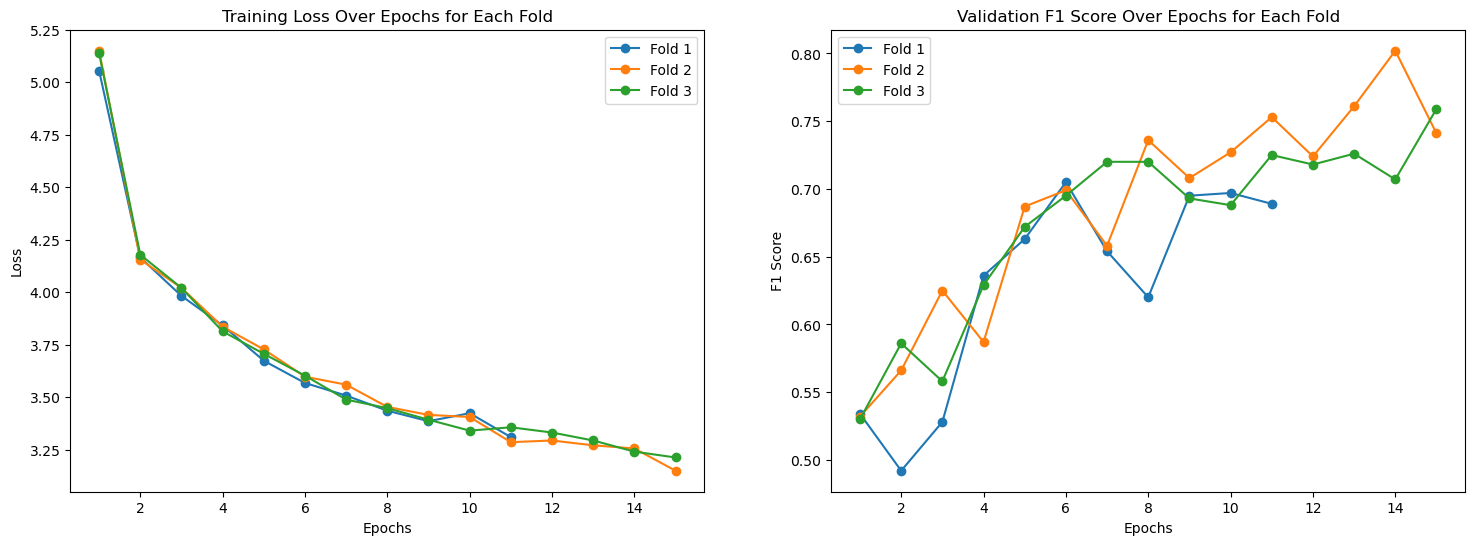

In [ ]:
import matplotlib.pyplot as plt

# Hardcoded training data for each fold based on the provided logs
# Losses (summing box_loss, cls_loss, and dfl_loss per epoch) and F1 scores for each epoch in each fold
fold_losses = [
    [5.055, 4.165, 3.982, 3.841, 3.673, 3.567, 3.507, 3.435, 3.385, 3.423, 3.309],
    [5.15, 4.155, 4.02, 3.835, 3.727, 3.597, 3.559, 3.453, 3.415, 3.405, 3.285, 3.293, 3.270, 3.255, 3.149],
    [5.138, 4.178, 4.02, 3.813, 3.706, 3.602, 3.488, 3.447, 3.392, 3.34, 3.356, 3.331, 3.293, 3.24, 3.212]
    ]

fold_f1_scores = [
    [0.534, 0.492, 0.528, 0.636, 0.663, 0.705, 0.654, 0.62, 0.695, 0.697, 0.689],
    [0.532, 0.566, 0.625, 0.587, 0.687, 0.699, 0.658, 0.736, 0.708, 0.727, 0.753, 0.724, 0.761, 0.802, 0.741],
    [0.53, 0.586, 0.558, 0.629, 0.672, 0.695, 0.72, 0.72, 0.693, 0.688, 0.725, 0.718, 0.726, 0.707, 0.759]
    ]



# Plotting Training Loss and Validation F1 Score for Each Fold
plt.figure(figsize=(18, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
for i, loss in enumerate(fold_losses, 1):
    plt.plot(range(1, len(loss) + 1), loss, label=f'Fold {i}', marker='o')
plt.title("Training Loss Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Validation F1 Score
plt.subplot(1, 2, 2)
for i, fold_f1 in enumerate(fold_f1_scores, 1):
    plt.plot(range(1, len(fold_f1) + 1), fold_f1, label=f'Fold {i}', marker='o')
plt.title("Validation F1 Score Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

plt.show()


**Inference (Make Predictions)**

Loaded model from fold_1
Loaded model from fold_2
Loaded model from fold_3
Performing prediction with fold_1 model...
Performing prediction with fold_2 model...
Performing prediction with fold_3 model...


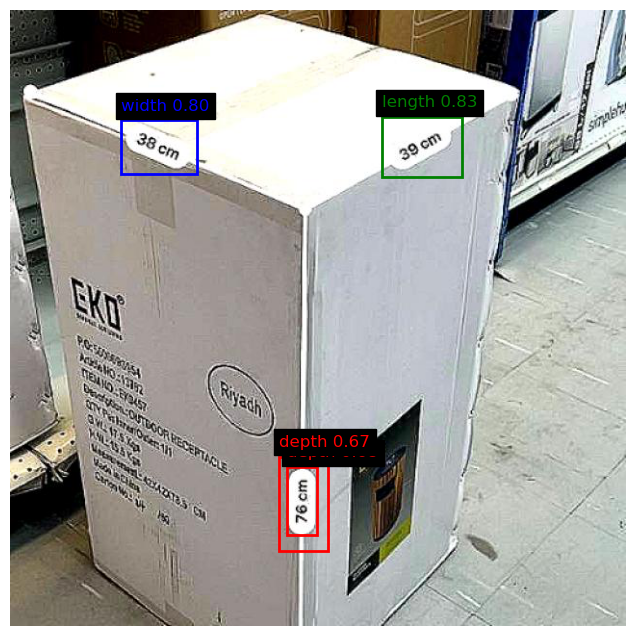

In [ ]:
import os
import shutil
from sklearn.model_selection import KFold
from ultralytics import YOLO
import torch
from torchvision.ops import nms
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Define your root directory
ROOT_DIR = ''
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds2')

# Load the five trained models
models = []
for fold in range(1, 4):
    best_weights_path = os.path.join(FOLDS_DIR, f'fold_{fold}', 'runs', 'train', 'weights', 'best.pt')
    if os.path.exists(best_weights_path):
        model = YOLO(best_weights_path)
        models.append(model)
        print(f"Loaded model from fold_{fold}")
    else:
        print(f"Best weights not found for fold_{fold} at {best_weights_path}")

# Path to your test image
test_image_path = "Methodology.2.v5i.yolov8/train/images/GG_methodology2_-106-_jpg.rf.61f91a520d1d6391c12a9bd307c1dae9.jpg"

# Open and display the original image
image = Image.open(test_image_path)

# List to store all detections from all models
all_detections = []

# Perform prediction with each model
for idx, model in enumerate(models):
    print(f"Performing prediction with fold_{idx+1} model...")
    results = model.predict(source=test_image_path, conf=0.6, iou=0.5, augment=True, agnostic_nms=True, verbose=False)
    all_detections.append(results[0].boxes)  # Assuming single image input

# Aggregate detections
boxes = []
scores = []
classes = []

for detection in all_detections:
    if detection is not None and len(detection) > 0:
        boxes.append(detection.xyxy)
        scores.append(detection.conf)
        classes.append(detection.cls)

if boxes:
    all_boxes = torch.cat(boxes)
    all_scores = torch.cat(scores)
    all_classes = torch.cat(classes)
else:
    print("No detections found from any model.")
    all_boxes = torch.tensor([])
    all_scores = torch.tensor([])
    all_classes = torch.tensor([])

# Apply NMS to combine predictions from the 5 models
iou_threshold = 0.8
if all_boxes.numel() > 0:
    all_classes = all_classes.int()
    final_boxes = []
    final_scores = []
    final_classes = []

    unique_classes = all_classes.unique()
    for cls in unique_classes:
        cls_indices = (all_classes == cls).nonzero(as_tuple=True)[0]
        cls_boxes = all_boxes[cls_indices]
        cls_scores = all_scores[cls_indices]
        keep = nms(cls_boxes, cls_scores, iou_threshold)
        final_boxes.append(cls_boxes[keep])
        final_scores.append(cls_scores[keep])
        final_classes.append(all_classes[cls_indices][keep])

    if final_boxes:
        final_boxes = torch.cat(final_boxes)
        final_scores = torch.cat(final_scores)
        final_classes = torch.cat(final_classes)
    else:
        final_boxes = torch.tensor([])
        final_scores = torch.tensor([])
        final_classes = torch.tensor([])
else:
    print("No detections to perform NMS.")
    final_boxes = torch.tensor([])
    final_scores = torch.tensor([])
    final_classes = torch.tensor([])

# Function to draw bounding boxes
def draw_boxes(image_path, boxes, scores, classes, class_names):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan']

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box.tolist()
        width, height = x2 - x1, y2 - y1
        color = colors[cls % len(colors)]
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        label = f"{class_names[cls]} {score:.2f}"
        plt.text(x1, y1 - 10, label, fontsize=12, color=color, backgroundcolor="black")

    plt.axis('off')
    plt.show()

# Define class names (ensure they match your training)
class_names = ['depth', 'length', 'width']  # Replace with your actual class names

# Draw the final boxes on the image
if final_boxes.numel() > 0:
    draw_boxes(test_image_path, final_boxes, final_scores, final_classes, class_names)
else:
    print("No boxes to display.")


# FasterRCNN

**Custom Dataset Class and Data Preparation**

In [ ]:
# 1st Cell: Data Preparation with K-Fold

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom Dataset Class to load data in COCO format
class CustomDataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        with open(annotations_file) as f:
            self.annotations = json.load(f)
        self.images = self.annotations['images']
        self.annotations_dict = {img['id']: [] for img in self.images}

        for ann in self.annotations['annotations']:
            self.annotations_dict[ann['image_id']].append(ann)

        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image or skip as per requirement
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            # Alternatively, you can skip this sample
            # return None, None

        boxes = []
        labels = []
        for ann in self.annotations_dict[img_info['id']]:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {
            "image_id": torch.tensor([img_info['id']]),
            "boxes": boxes,
            "labels": labels
        }

        return image, target

# Transformations for images
transform = transforms.Compose([transforms.ToTensor()])

# Function to create DataLoaders for a given fold
def create_data_loaders(fold_dir, batch_size=4, num_workers=2):
    train_annotations_file = os.path.join(fold_dir, 'train', 'annotations', '_annotations.coco.json')
    train_images_dir = os.path.join(fold_dir, 'train', 'images')
    val_annotations_file = os.path.join(fold_dir, 'val', 'annotations', '_annotations.coco.json')
    val_images_dir = os.path.join(fold_dir, 'val', 'images')

    # Create dataset instances
    train_dataset = CustomDataset(train_annotations_file, train_images_dir, transform=transform)
    val_dataset = CustomDataset(val_annotations_file, val_images_dir, transform=transform)

    # Collate function to combine batch samples
    def collate_fn(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

    # DataLoaders with collate_fn
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    return train_data_loader, val_data_loader


**Model Setup and Optimizer**

In [ ]:
# 2nd Cell: Model Setup with K-Fold

from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
import torch

# Function to get a new Faster R-CNN model
def get_faster_rcnn_model():

    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    return model


**Training Loop with Loss and F1 Score Tracking**

In [ ]:
# 3rd Cell: Training and Evaluation with K-Fold

import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import torch
from tqdm import tqdm

num_epochs = 30
patience = 5
best_f1 = 0.0
epochs_without_improvement = 0

# Function to compute F1 score for validation
def compute_f1(model, val_data_loader, device):
    model.eval()
    true_positives, false_positives, false_negatives = 0, 0, 0

    with torch.no_grad():
        for images, targets in tqdm(val_data_loader, desc="Validation"):
            if not images:
                continue

            images = [image.to(device) for image in images]

            for output, target in zip(model(images), targets):
                if not isinstance(target, dict):
                    print(f"Unexpected target format: {target}")
                    continue

                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                if gt_boxes.numel() == 0:
                    # No ground truth boxes
                    false_positives += pred_boxes.size(0)
                    continue

                if pred_boxes.numel() == 0:
                    # No predicted boxes
                    false_negatives += gt_boxes.size(0)
                    continue

                # Compute IoU between predicted and ground truth boxes
                ious = box_iou(pred_boxes, gt_boxes)

                # Match predictions to ground truths
                matched_preds = torch.zeros(pred_boxes.size(0), dtype=torch.bool).to(device)
                matched_gts = torch.zeros(gt_boxes.size(0), dtype=torch.bool).to(device)

                for pred_idx in range(pred_boxes.size(0)):
                    # Find the gt with the highest IoU for this prediction
                    iou, gt_idx = torch.max(ious[pred_idx], dim=0)
                    if iou >= 0.5 and not matched_gts[gt_idx]:
                        matched_preds[pred_idx] = True
                        matched_gts[gt_idx] = True

                true_positives += matched_preds.sum().item()
                false_positives += (~matched_preds).sum().item()
                false_negatives += (~matched_gts).sum().item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

# Function to train and evaluate on a single fold
def train_and_evaluate_fold(fold_dir, num_classes, device, num_epochs=30, batch_size=4, patience=5):
    print(f"Starting Fold: {fold_dir}")

    # Create DataLoaders
    train_data_loader, val_data_loader = create_data_loaders(fold_dir, batch_size=batch_size, num_workers=2)

    # Initialize the model
    model = get_faster_rcnn_model()
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=patience//2, verbose=True)

    best_f1 = 0.0
    epochs_without_improvement = 0
    best_model_path = os.path.join(fold_dir, 'fasterrcnn_best.pt')

    train_loss_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        scaler = torch.cuda.amp.GradScaler()

        for images, targets in tqdm(train_data_loader, desc=f"Fold {fold_dir} - Training Epoch {epoch+1}"):
            if not images:
                continue

            # Move images to the device
            images = [image.to(device) for image in images]

            # Process targets and move them to the device
            processed_targets = []
            for i in range(len(images)):
                boxes = targets[i]['boxes'].to(device)
                labels = targets[i]['labels'].to(device)
                processed_targets.append({'boxes': boxes, 'labels': labels})

            if not processed_targets:
                continue

            optimizer.zero_grad()

            # Forward pass with autocast for mixed precision
            with torch.cuda.amp.autocast():
                loss_dict = model(images, processed_targets)
                losses = sum(loss for loss in loss_dict.values())

            # Scales the loss, and calls backward()
            scaler.scale(losses).backward()

            # Unscales gradients and performs optimizer step
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()

            epoch_loss += losses.item()

        avg_train_loss = epoch_loss / len(train_data_loader)
        train_loss_history.append(avg_train_loss)

        # Compute F1 score on validation set
        f1_score = compute_f1(model, val_data_loader, device)
        val_f1_history.append(f1_score)

        print(f"Fold {fold_dir} Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}, F1 Score: {f1_score:.4f}")

        # Step the scheduler
        scheduler.step(f1_score)

        # Check for improvement
        if f1_score > best_f1:
            best_f1 = f1_score
            epochs_without_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"New best F1 score: {best_f1:.4f}. Model saved.")
        else:
            epochs_without_improvement += 1
            print(f"No improvement in F1 score for {epochs_without_improvement} epoch(s).")

        # Early Stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    print(f"Best model for fold {fold_dir} loaded from {best_model_path}")

    return {
        'fold': fold_dir,
        'train_loss_history': train_loss_history,
        'val_f1_history': val_f1_history,
        'best_f1': best_f1
    }


In [ ]:
# 4th Cell: Aggregating Metrics Across All Folds

import matplotlib.pyplot as plt

# Define class names (including background if applicable)
class_names = ['depth', 'length', 'width']

# Initialize lists to store metrics from all folds
all_train_losses = []
all_val_f1_scores = []
best_f1_scores = []

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 3
# Iterate through each fold and train/evaluate
for fold in range(1, K+1):
    fold_dir = os.path.join(FOLDS_DIR, f'fold_{fold}')
    metrics = train_and_evaluate_fold(
        fold_dir=fold_dir,
        num_classes=3,
        device=device,
        num_epochs=num_epochs,
        batch_size=4,
        patience=patience
    )
    all_train_losses.append(metrics['train_loss_history'])
    all_val_f1_scores.append(metrics['val_f1_history'])
    best_f1_scores.append(metrics['best_f1'])

# Compute average metrics
average_train_losses = [sum(x)/len(x) for x in zip(*all_train_losses)]
average_val_f1 = [sum(x)/len(x) for x in zip(*all_val_f1_scores)]
overall_best_f1 = sum(best_f1_scores) / len(best_f1_scores)

print(f"\nAverage Best F1 Score across {K} folds: {overall_best_f1:.4f}")

Starting Fold: Methodology.2.v5i.coco/folds/fold_1


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_3475939/1787233659.py:99: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 1:   0%|                             | 0/138 [00:00<?, ?it/s]/tmp/ipykernel_3475939/1787233659.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 1: 100%|███████████████████| 138/138 [00:20<00:00,  6.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.65it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [1/30], Loss: 0.2347, F1 Score: 0.6181
New best F1 score: 0.6181. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 2: 100%|███████████████████| 138/138 [00:21<00:00,  6.53it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:10<00:00, 25.75it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [2/30], Loss: 0.1947, F1 Score: 0.6535
New best F1 score: 0.6535. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 3: 100%|███████████████████| 138/138 [00:20<00:00,  6.59it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:10<00:00, 26.91it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [3/30], Loss: 0.1571, F1 Score: 0.7167
New best F1 score: 0.7167. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 4: 100%|███████████████████| 138/138 [00:19<00:00,  7.20it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.27it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [4/30], Loss: 0.1326, F1 Score: 0.7624
New best F1 score: 0.7624. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 5: 100%|███████████████████| 138/138 [00:20<00:00,  6.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.72it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [5/30], Loss: 0.1140, F1 Score: 0.8057
New best F1 score: 0.8057. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 6: 100%|███████████████████| 138/138 [00:19<00:00,  7.15it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.24it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [6/30], Loss: 0.0990, F1 Score: 0.8272
New best F1 score: 0.8272. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 7: 100%|███████████████████| 138/138 [00:20<00:00,  6.84it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.97it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [7/30], Loss: 0.0922, F1 Score: 0.7866
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 8: 100%|███████████████████| 138/138 [00:20<00:00,  6.86it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 24.10it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [8/30], Loss: 0.0809, F1 Score: 0.8338
New best F1 score: 0.8338. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 9: 100%|███████████████████| 138/138 [00:18<00:00,  7.28it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 24.71it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [9/30], Loss: 0.0725, F1 Score: 0.8430
New best F1 score: 0.8430. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 10: 100%|██████████████████| 138/138 [00:20<00:00,  6.66it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.61it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [10/30], Loss: 0.0599, F1 Score: 0.8725
New best F1 score: 0.8725. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 11: 100%|██████████████████| 138/138 [00:20<00:00,  6.65it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.21it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [11/30], Loss: 0.0547, F1 Score: 0.8691
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 12: 100%|██████████████████| 138/138 [00:19<00:00,  6.95it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.82it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [12/30], Loss: 0.0530, F1 Score: 0.8690
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 13: 100%|██████████████████| 138/138 [00:20<00:00,  6.68it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.56it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [13/30], Loss: 0.0600, F1 Score: 0.8633
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 14: 100%|██████████████████| 138/138 [00:21<00:00,  6.42it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 23.08it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [14/30], Loss: 0.0475, F1 Score: 0.8580
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 15: 100%|██████████████████| 138/138 [00:20<00:00,  6.70it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:10<00:00, 25.13it/s]
/tmp/ipykernel_3475939/1787233659.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [15/30], Loss: 0.0355, F1 Score: 0.8694
No improvement in F1 score for 5 epoch(s).
Early stopping triggered after 15 epochs.
Best model for fold Methodology.2.v5i.coco/folds/fold_1 loaded from Methodology.2.v5i.coco/folds/fold_1/fasterrcnn_best.pt
Starting Fold: Methodology.2.v5i.coco/folds/fold_2


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 1: 100%|███████████████████| 138/138 [00:20<00:00,  6.85it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.66it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [1/30], Loss: 0.2347, F1 Score: 0.6724
New best F1 score: 0.6724. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 2: 100%|███████████████████| 138/138 [00:19<00:00,  7.09it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.79it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [2/30], Loss: 0.1867, F1 Score: 0.6827
New best F1 score: 0.6827. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 3: 100%|███████████████████| 138/138 [00:19<00:00,  7.06it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.37it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [3/30], Loss: 0.1494, F1 Score: 0.6416
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 4: 100%|███████████████████| 138/138 [00:20<00:00,  6.71it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.39it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [4/30], Loss: 0.1357, F1 Score: 0.7595
New best F1 score: 0.7595. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 5: 100%|███████████████████| 138/138 [00:22<00:00,  6.25it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.14it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [5/30], Loss: 0.1101, F1 Score: 0.8389
New best F1 score: 0.8389. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 6: 100%|███████████████████| 138/138 [00:20<00:00,  6.61it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.92it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [6/30], Loss: 0.0929, F1 Score: 0.8162
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 7: 100%|███████████████████| 138/138 [00:20<00:00,  6.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.33it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [7/30], Loss: 0.0802, F1 Score: 0.8014
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 8: 100%|███████████████████| 138/138 [00:20<00:00,  6.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.11it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [8/30], Loss: 0.0834, F1 Score: 0.8093
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 9: 100%|███████████████████| 138/138 [00:20<00:00,  6.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.38it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [9/30], Loss: 0.0608, F1 Score: 0.8307
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 10: 100%|██████████████████| 138/138 [00:19<00:00,  7.21it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.69it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [10/30], Loss: 0.0475, F1 Score: 0.8398
New best F1 score: 0.8398. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 11: 100%|██████████████████| 138/138 [00:19<00:00,  6.97it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.85it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [11/30], Loss: 0.0413, F1 Score: 0.8491
New best F1 score: 0.8491. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 12: 100%|██████████████████| 138/138 [00:21<00:00,  6.48it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.87it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [12/30], Loss: 0.0364, F1 Score: 0.8522
New best F1 score: 0.8522. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 13: 100%|██████████████████| 138/138 [00:20<00:00,  6.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.64it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [13/30], Loss: 0.0328, F1 Score: 0.8632
New best F1 score: 0.8632. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 14: 100%|██████████████████| 138/138 [00:20<00:00,  6.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.76it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [14/30], Loss: 0.0298, F1 Score: 0.8628
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 15: 100%|██████████████████| 138/138 [00:18<00:00,  7.40it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.34it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [15/30], Loss: 0.0276, F1 Score: 0.8642
New best F1 score: 0.8642. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 16: 100%|██████████████████| 138/138 [00:21<00:00,  6.32it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.76it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [16/30], Loss: 0.0255, F1 Score: 0.8682
New best F1 score: 0.8682. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 17: 100%|██████████████████| 138/138 [00:20<00:00,  6.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:09<00:00, 29.43it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [17/30], Loss: 0.0241, F1 Score: 0.8704
New best F1 score: 0.8704. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 18: 100%|██████████████████| 138/138 [00:19<00:00,  7.24it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.62it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [18/30], Loss: 0.0228, F1 Score: 0.8708
New best F1 score: 0.8708. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 19: 100%|██████████████████| 138/138 [00:21<00:00,  6.54it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.39it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [19/30], Loss: 0.0221, F1 Score: 0.8725
New best F1 score: 0.8725. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 20: 100%|██████████████████| 138/138 [00:19<00:00,  7.10it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.17it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [20/30], Loss: 0.0211, F1 Score: 0.8811
New best F1 score: 0.8811. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 21: 100%|██████████████████| 138/138 [00:19<00:00,  7.05it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.21it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [21/30], Loss: 0.0205, F1 Score: 0.8837
New best F1 score: 0.8837. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 22: 100%|██████████████████| 138/138 [00:20<00:00,  6.82it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.34it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [22/30], Loss: 0.0197, F1 Score: 0.8767
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 23: 100%|██████████████████| 138/138 [00:20<00:00,  6.62it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.79it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [23/30], Loss: 0.0197, F1 Score: 0.8814
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 24: 100%|██████████████████| 138/138 [00:19<00:00,  7.12it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.26it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [24/30], Loss: 0.0184, F1 Score: 0.8773
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 25: 100%|██████████████████| 138/138 [00:20<00:00,  6.67it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.20it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [25/30], Loss: 0.0171, F1 Score: 0.8791
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 26: 100%|██████████████████| 138/138 [00:20<00:00,  6.58it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.21it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [26/30], Loss: 0.0163, F1 Score: 0.8778
No improvement in F1 score for 5 epoch(s).
Early stopping triggered after 26 epochs.
Best model for fold Methodology.2.v5i.coco/folds/fold_2 loaded from Methodology.2.v5i.coco/folds/fold_2/fasterrcnn_best.pt
Starting Fold: Methodology.2.v5i.coco/folds/fold_3


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 1: 100%|███████████████████| 138/138 [00:19<00:00,  6.98it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.53it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [1/30], Loss: 0.2431, F1 Score: 0.6499
New best F1 score: 0.6499. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 2: 100%|███████████████████| 138/138 [00:18<00:00,  7.27it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.86it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [2/30], Loss: 0.1904, F1 Score: 0.6865
New best F1 score: 0.6865. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 3: 100%|███████████████████| 138/138 [00:19<00:00,  7.11it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 22.96it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [3/30], Loss: 0.1615, F1 Score: 0.7222
New best F1 score: 0.7222. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 4: 100%|███████████████████| 138/138 [00:20<00:00,  6.90it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.08it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [4/30], Loss: 0.1523, F1 Score: 0.7110
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 5: 100%|███████████████████| 138/138 [00:19<00:00,  7.11it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:09<00:00, 27.68it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [5/30], Loss: 0.1215, F1 Score: 0.7803
New best F1 score: 0.7803. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 6: 100%|███████████████████| 138/138 [00:20<00:00,  6.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.35it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [6/30], Loss: 0.1052, F1 Score: 0.8161
New best F1 score: 0.8161. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 7: 100%|███████████████████| 138/138 [00:20<00:00,  6.88it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.39it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [7/30], Loss: 0.0890, F1 Score: 0.8189
New best F1 score: 0.8189. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 8: 100%|███████████████████| 138/138 [00:20<00:00,  6.69it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.74it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [8/30], Loss: 0.0814, F1 Score: 0.8408
New best F1 score: 0.8408. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 9: 100%|███████████████████| 138/138 [00:19<00:00,  6.91it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.32it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [9/30], Loss: 0.0746, F1 Score: 0.8463
New best F1 score: 0.8463. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 10: 100%|██████████████████| 138/138 [00:19<00:00,  7.11it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.15it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [10/30], Loss: 0.0735, F1 Score: 0.8327
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 11: 100%|██████████████████| 138/138 [00:21<00:00,  6.39it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 26.05it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [11/30], Loss: 0.0612, F1 Score: 0.8668
New best F1 score: 0.8668. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 12: 100%|██████████████████| 138/138 [00:19<00:00,  7.23it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.02it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [12/30], Loss: 0.0555, F1 Score: 0.8683
New best F1 score: 0.8683. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 13: 100%|██████████████████| 138/138 [00:17<00:00,  7.68it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.81it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [13/30], Loss: 0.0506, F1 Score: 0.8694
New best F1 score: 0.8694. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 14: 100%|██████████████████| 138/138 [00:20<00:00,  6.65it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.67it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [14/30], Loss: 0.0450, F1 Score: 0.8822
New best F1 score: 0.8822. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 15: 100%|██████████████████| 138/138 [00:21<00:00,  6.42it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:09<00:00, 27.85it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [15/30], Loss: 0.0422, F1 Score: 0.8755
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 16: 100%|██████████████████| 138/138 [00:19<00:00,  6.93it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.03it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [16/30], Loss: 0.0394, F1 Score: 0.8726
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 17: 100%|██████████████████| 138/138 [00:21<00:00,  6.43it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.50it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [17/30], Loss: 0.0377, F1 Score: 0.8868
New best F1 score: 0.8868. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 18: 100%|██████████████████| 138/138 [00:21<00:00,  6.57it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.48it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [18/30], Loss: 0.0351, F1 Score: 0.8836
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 19: 100%|██████████████████| 138/138 [00:20<00:00,  6.80it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.59it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [19/30], Loss: 0.0340, F1 Score: 0.8757
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 20: 100%|██████████████████| 138/138 [00:20<00:00,  6.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.18it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [20/30], Loss: 0.0335, F1 Score: 0.8837
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 21: 100%|██████████████████| 138/138 [00:20<00:00,  6.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.59it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [21/30], Loss: 0.0272, F1 Score: 0.8880
New best F1 score: 0.8880. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 22: 100%|██████████████████| 138/138 [00:20<00:00,  6.67it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.91it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [22/30], Loss: 0.0217, F1 Score: 0.8905
New best F1 score: 0.8905. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 23: 100%|██████████████████| 138/138 [00:20<00:00,  6.71it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 26.40it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [23/30], Loss: 0.0189, F1 Score: 0.8919
New best F1 score: 0.8919. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 24: 100%|██████████████████| 138/138 [00:20<00:00,  6.69it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.16it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [24/30], Loss: 0.0169, F1 Score: 0.8919
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 25: 100%|██████████████████| 138/138 [00:21<00:00,  6.40it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.90it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [25/30], Loss: 0.0155, F1 Score: 0.8929
New best F1 score: 0.8929. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 26: 100%|██████████████████| 138/138 [00:17<00:00,  7.76it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.94it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [26/30], Loss: 0.0141, F1 Score: 0.8989
New best F1 score: 0.8989. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 27: 100%|██████████████████| 138/138 [00:19<00:00,  6.92it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.52it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [27/30], Loss: 0.0131, F1 Score: 0.8999
New best F1 score: 0.8999. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 28: 100%|██████████████████| 138/138 [00:19<00:00,  7.04it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.17it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [28/30], Loss: 0.0123, F1 Score: 0.8945
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 29: 100%|██████████████████| 138/138 [00:21<00:00,  6.57it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:10<00:00, 25.16it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [29/30], Loss: 0.0120, F1 Score: 0.8970
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 30: 100%|██████████████████| 138/138 [00:19<00:00,  7.06it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 24.85it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [30/30], Loss: 0.0115, F1 Score: 0.8984
No improvement in F1 score for 3 epoch(s).
Best model for fold Methodology.2.v5i.coco/folds/fold_3 loaded from Methodology.2.v5i.coco/folds/fold_3/fasterrcnn_best.pt

Average Best F1 Score across 3 folds: 0.8854


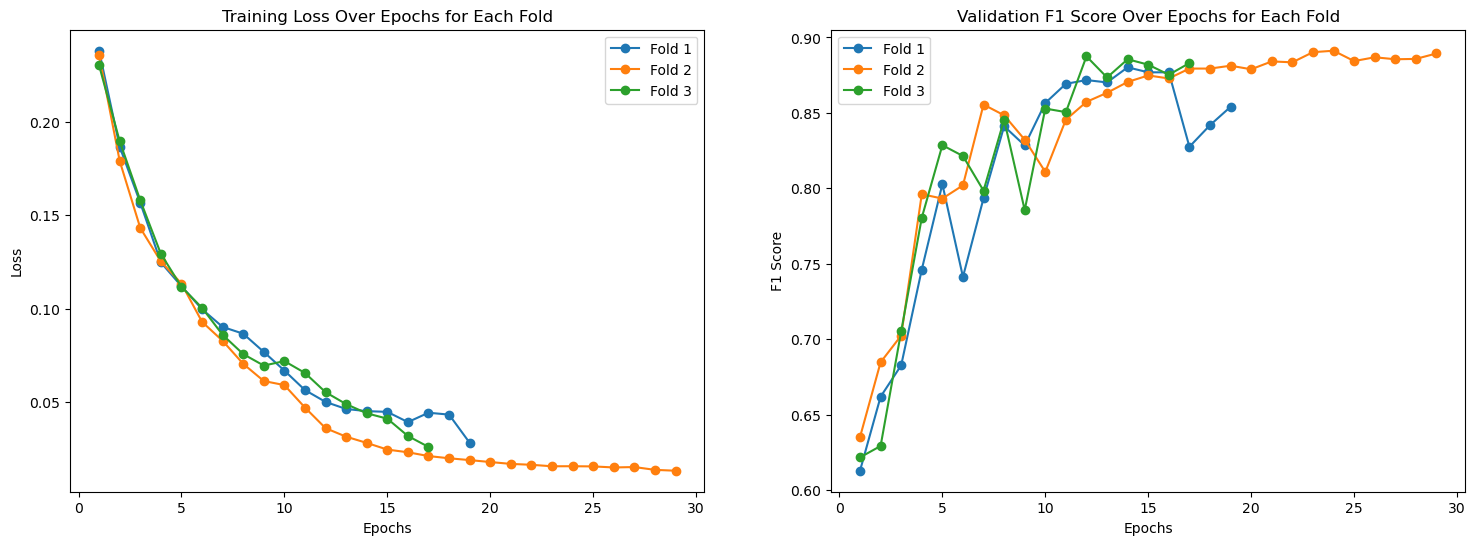

In [ ]:
# Plotting Training Loss and Validation F1 Score for Each Fold
plt.figure(figsize=(18, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
for i, fold_losses in enumerate(all_train_losses, 1):
    plt.plot(range(1, len(fold_losses) + 1), fold_losses, label=f'Fold {i}', marker='o')
plt.title("Training Loss Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Validation F1 Score
plt.subplot(1, 2, 2)
for i, fold_f1 in enumerate(all_val_f1_scores, 1):
    plt.plot(range(1, len(fold_f1) + 1), fold_f1, label=f'Fold {i}', marker='o')
plt.title("Validation F1 Score Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

plt.show()


**Evaluation**

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import torch
from torchvision.ops import box_iou, nms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2


ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 5  # Number of folds
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = {1: 'depth', 2: 'length', 3: 'width'}

def load_trained_model(weights_path, num_classes, device):
    model = fasterrcnn_resnet50_fpn_v2(pretrained=False)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def collate_fn(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

def evaluate_custom_with_map_single_fold(faster_model, data_loader, device, iou_thresholds=None, score_threshold=0.5, nms_threshold=0.5):
    if iou_thresholds is None:
        iou_thresholds = [0.5 + 0.05 * i for i in range(10)]  # IoU thresholds from 0.5 to 0.95

    faster_model.eval()

    # Initialize counters for AP per class and IoU threshold
    true_positives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}
    false_positives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}
    false_negatives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}

    # Initialize counters for F1 score
    f1_true_positives = 0
    f1_false_positives = 0
    f1_false_negatives = 0
    f1_iou_threshold = 0.5  # Fixed IoU threshold for F1

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            if not images:
                continue

            images = [img.to(device) for img in images]

            outputs = faster_model(images)

            for output, target in zip(outputs, targets):
                if not isinstance(target, dict):
                    print(f"Unexpected target format: {target}")
                    continue

                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                # Filter by score threshold
                high_conf_idx = pred_scores >= score_threshold
                pred_boxes = pred_boxes[high_conf_idx]
                pred_scores = pred_scores[high_conf_idx]
                pred_labels = pred_labels[high_conf_idx]

                if len(pred_boxes) == 0:
                    # No predictions, all GT boxes are false negatives
                    for gt_label in gt_labels:
                        class_name = class_names.get(gt_label.item(), 'unknown')
                        for iou in iou_thresholds:
                            false_negatives_per_class[iou][class_name] += 1
                    # Update F1 false negatives
                    f1_false_negatives += len(gt_labels)
                    continue

                # Apply Non-Maximum Suppression (NMS)
                keep_indices = nms(pred_boxes, pred_scores, nms_threshold)
                pred_boxes = pred_boxes[keep_indices]
                pred_scores = pred_scores[keep_indices]
                pred_labels = pred_labels[keep_indices]

                if len(pred_boxes) == 0:
                    # No predictions after NMS, all GT boxes are false negatives
                    for gt_label in gt_labels:
                        class_name = class_names.get(gt_label.item(), 'unknown')
                        for iou in iou_thresholds:
                            false_negatives_per_class[iou][class_name] += 1
                    # Update F1 false negatives
                    f1_false_negatives += len(gt_labels)
                    continue

                # Compute IoU between predicted and ground truth boxes
                ious = box_iou(pred_boxes, gt_boxes)

                # --- mAP Calculation ---
                for iou_threshold in iou_thresholds:
                    matched_pred = torch.zeros(len(pred_boxes), dtype=torch.bool).to(device)
                    matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool).to(device)

                    for pred_idx in range(len(pred_boxes)):
                        iou_vals = ious[pred_idx]
                        max_iou, gt_idx = torch.max(iou_vals, dim=0)

                        if max_iou >= iou_threshold and not matched_gt[gt_idx]:
                            matched_pred[pred_idx] = True
                            matched_gt[gt_idx] = True
                            class_name = class_names.get(gt_labels[gt_idx].item(), 'unknown')
                            true_positives_per_class[iou_threshold][class_name] += 1
                        else:
                            class_name = class_names.get(pred_labels[pred_idx].item(), 'unknown')
                            false_positives_per_class[iou_threshold][class_name] += 1

                    for gt_idx in range(len(gt_boxes)):
                        if not matched_gt[gt_idx]:
                            class_name = class_names.get(gt_labels[gt_idx].item(), 'unknown')
                            false_negatives_per_class[iou_threshold][class_name] += 1

                # --- F1 Score Calculation ---
                # For F1, use fixed IoU threshold of 0.5
                if f1_iou_threshold in iou_thresholds:
                    # Find matches with IoU >= 0.5
                    matched_pred_f1 = torch.zeros(len(pred_boxes), dtype=torch.bool).to(device)
                    matched_gt_f1 = torch.zeros(len(gt_boxes), dtype=torch.bool).to(device)

                    for pred_idx in range(len(pred_boxes)):
                        iou_val = ious[pred_idx]
                        max_iou, gt_idx = torch.max(iou_val, dim=0)
                        if max_iou >= f1_iou_threshold and not matched_gt_f1[gt_idx]:
                            matched_pred_f1[pred_idx] = True
                            matched_gt_f1[gt_idx] = True
                            f1_true_positives += 1
                        else:
                            f1_false_positives += 1

                    # Count unmatched ground truths as false negatives
                    f1_false_negatives += (~matched_gt_f1).sum().item()

        # --- Calculate mAP ---
        mean_ap = 0
        per_class_map = defaultdict(list)  # To store per-class AP
        for iou_threshold in iou_thresholds:
            ap_per_class = []

            for class_name in class_names.values():
                tp = true_positives_per_class[iou_threshold][class_name]
                fp = false_positives_per_class[iou_threshold][class_name]
                fn = false_negatives_per_class[iou_threshold][class_name]

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                ap = precision  # AP is precision at the fixed IoU threshold
                ap_per_class.append(ap)
                per_class_map[class_name].append(ap)

            mean_ap += sum(ap_per_class) / len(ap_per_class) if ap_per_class else 0

        mean_ap /= len(iou_thresholds)

        # --- Calculate F1 Score ---
        precision_f1 = f1_true_positives / (f1_true_positives + f1_false_positives) if (f1_true_positives + f1_false_positives) > 0 else 0
        recall_f1 = f1_true_positives / (f1_true_positives + f1_false_negatives) if (f1_true_positives + f1_false_negatives) > 0 else 0
        f1_score = 2 * (precision_f1 * recall_f1) / (precision_f1 + recall_f1) if (precision_f1 + recall_f1) > 0 else 0

        return {
            'mean_ap': mean_ap,
            'class_map': per_class_map,
            'f1_score': f1_score
        }



fold_metrics = []


for fold in range(1, K+1):
    print(f"\n--- Evaluating Fold {fold} ---")

    fold_dir = os.path.join(FOLDS_DIR, f'fold_{fold}')
    model_weights_path = os.path.join(fold_dir, 'fasterrcnn_best.pt')

    # Check if the model weights exist
    if not os.path.exists(model_weights_path):
        print(f"Model weights not found for Fold {fold} at {model_weights_path}. Skipping this fold.")
        continue

    # Load the trained model
    model = load_trained_model(model_weights_path, NUM_CLASSES, DEVICE)
    print(f"Loaded model for Fold {fold} from {model_weights_path}")

    # Load the validation dataset and DataLoader for this fold
    val_annotations_file = os.path.join(fold_dir, 'val', 'annotations', '_annotations.coco.json')
    val_images_dir = os.path.join(fold_dir, 'val', 'images')

    # Initialize the validation dataset
    val_dataset = CustomDataset(val_annotations_file, val_images_dir, transform=transform)

    # Initialize the DataLoader
    val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

    # Evaluate the model on the validation set
    metrics = evaluate_custom_with_map_single_fold(
        faster_model=model,
        data_loader=val_data_loader,
        device=DEVICE,
        iou_thresholds=[0.5 + 0.05 * i for i in range(10)],  # IoU thresholds from 0.5 to 0.95
        score_threshold=0.5,  # Ensure consistency with training
        nms_threshold=0.5
    )

    # Store the metrics along with the fold number
    fold_metrics.append({
        'fold': fold,
        'mean_ap': metrics['mean_ap'],
        'f1_score': metrics['f1_score'],
        'class_map': metrics['class_map']
    })


--- Evaluating Fold 1 ---


/tmp/ipykernel_1597762/3643092.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Loaded model for Fold 1 from Methodology.2.v5i.coco/folds/fold_1/fasterrcnn_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:44<00:00,  6.18it/s]



--- Evaluating Fold 2 ---
Loaded model for Fold 2 from Methodology.2.v5i.coco/folds/fold_2/fasterrcnn_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:38<00:00,  7.12it/s]



--- Evaluating Fold 3 ---
Loaded model for Fold 3 from Methodology.2.v5i.coco/folds/fold_3/fasterrcnn_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:43<00:00,  6.32it/s]


In [ ]:
total_map = sum([m['mean_ap'] for m in fold_metrics])

average_map = total_map / len(fold_metrics)
average_f1 = sum(best_f1_scores) / len(fold_metrics)

# Print detailed metrics for each fold
print("\n=== Cross-Validation Results ===")
print(f"Average F1 Score across all folds: {average_f1:.4f}")
print(f"Average mAP@0.5:0.95 across all folds: {average_map:.4f}")


=== Cross-Validation Results ===
Average F1 Score across all folds: 0.8863
Average mAP@0.5:0.95 across all folds: 0.7461


**Prediction Sample Image**

/tmp/ipykernel_1597762/4199150569.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Loaded Faster R-CNN model from fold_1
Loaded Faster R-CNN model from fold_2
Loaded Faster R-CNN model from fold_3
Model Fold 1 - Detections: 5
Model Fold 2 - Detections: 3
Model Fold 3 - Detections: 3
Final Detections after Ensembling 5 folds: 3


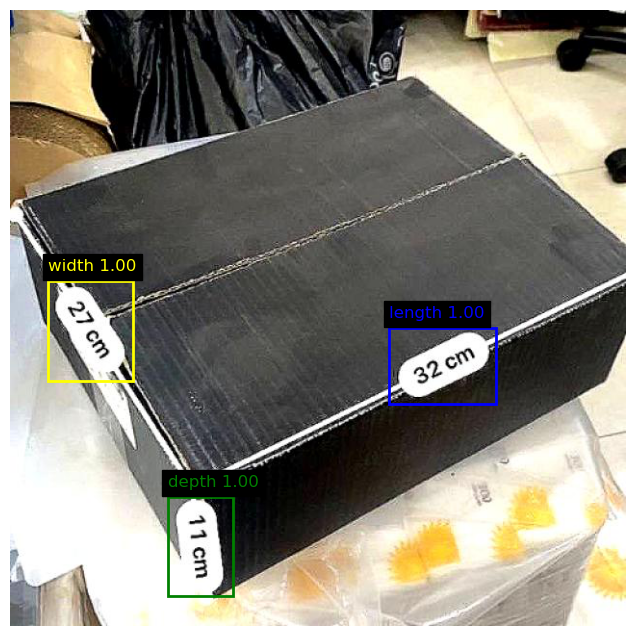

In [ ]:
import os
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.ops import nms, box_iou
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm


ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 3  # Number of folds
NUM_CLASSES = 3  # 3 classes + background
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = {1: 'depth', 2: 'length', 3: 'width'}


transform = transforms.Compose([transforms.ToTensor()])


def load_trained_model(weights_path, num_classes, device):
    model = fasterrcnn_resnet50_fpn_v2(pretrained=False)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model


models = []
for fold in range(1, K+1):
    weights_path = os.path.join(FOLDS_DIR, f'fold_{fold}', 'fasterrcnn_best.pt')
    if os.path.exists(weights_path):
        model = load_trained_model(weights_path, NUM_CLASSES, DEVICE)
        models.append(model)
        print(f"Loaded Faster R-CNN model from fold_{fold}")
    else:
        print(f"Model weights not found for fold_{fold} at {weights_path}")


test_image_path = "Methodology.2.v5i.coco/train/GG_methodology2_-101-_jpg.rf.2e49ac1d30e88a1f960a2ef177433a1b.jpg"  # Update this path as needed


image = Image.open(test_image_path).convert("RGB")
image_tensor = transform(image).to(DEVICE)


all_boxes = []
all_scores = []
all_labels = []

for idx, model in enumerate(models):
    with torch.no_grad():
        predictions = model([image_tensor])[0]

    boxes = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']

    # Filter out low-confidence predictions
    high_conf_idx = scores >= 0.5
    boxes = boxes[high_conf_idx]
    scores = scores[high_conf_idx]
    labels = labels[high_conf_idx]

    all_boxes.append(boxes)
    all_scores.append(scores)
    all_labels.append(labels)

    print(f"Model Fold {idx+1} - Detections: {len(boxes)}")


if all_boxes:
    all_boxes = torch.cat(all_boxes)
    all_scores = torch.cat(all_scores)
    all_labels = torch.cat(all_labels)
else:
    all_boxes = torch.empty((0, 4)).to(DEVICE)
    all_scores = torch.empty((0,)).to(DEVICE)
    all_labels = torch.empty((0,), dtype=torch.int64).to(DEVICE)


iou_threshold = 0.5  # Define your NMS IoU threshold

final_boxes = []
final_scores = []
final_labels = []

unique_labels = all_labels.unique()

for label in unique_labels:
    label_mask = all_labels == label
    boxes = all_boxes[label_mask]
    scores = all_scores[label_mask]

    if boxes.numel() == 0:
        continue

    if len(boxes) > 3:
        # Take only the most confident box
        top_score_idx = torch.argmax(scores)
        final_boxes.append(boxes[top_score_idx].unsqueeze(0))
        final_scores.append(scores[top_score_idx].unsqueeze(0))
        final_labels.append(all_labels[label_mask][top_score_idx].unsqueeze(0))
    else:
        # Apply NMS and keep all boxes
        keep = nms(boxes, scores, iou_threshold)
        final_boxes.append(boxes[keep])
        final_scores.append(scores[keep])
        final_labels.append(all_labels[label_mask][keep])

if final_boxes:
    final_boxes = torch.cat(final_boxes).cpu()
    final_scores = torch.cat(final_scores).cpu()
    final_labels = torch.cat(final_labels).cpu()
else:
    final_boxes = torch.empty((0, 4))
    final_scores = torch.empty((0,))
    final_labels = torch.empty((0,), dtype=torch.int64)

print(f"Final Detections after Ensembling 5 folds: {len(final_boxes)}")


def draw_boxes(image_path, boxes, scores, labels, class_names):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan']

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        width, height = x2 - x1, y2 - y1
        color = colors[label % len(colors)]
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        class_name = class_names.get(label.item(), 'Unknown')
        plt.text(x1, y1 - 10, f"{class_name} {score:.2f}", fontsize=12, color=color, backgroundcolor="black")

    plt.axis('off')
    plt.show()


class_names_list = ['depth', 'length', 'width']

draw_boxes(test_image_path, final_boxes, final_scores, final_labels, class_names)

# RetinaNet

**Custom Dataset Class and Data Preparation**

In [ ]:
# 1st Cell: Data Preparation with K-Fold

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom Dataset Class to load data in COCO format
class CustomDataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        with open(annotations_file) as f:
            self.annotations = json.load(f)
        self.images = self.annotations['images']
        self.annotations_dict = {img['id']: [] for img in self.images}

        for ann in self.annotations['annotations']:
            self.annotations_dict[ann['image_id']].append(ann)

        self.transform = transform
        self.images_dir = images_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image or skip as per requirement
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        boxes = []
        labels = []
        for ann in self.annotations_dict[img_info['id']]:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann['category_id'])

        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {
            "image_id": torch.tensor([img_info['id']]),
            "boxes": boxes,
            "labels": labels
        }

        return image, target

# Transformations for images
transform = transforms.Compose([transforms.ToTensor()])

# Function to create DataLoaders for a given fold
def create_data_loaders(fold_dir, batch_size=4, num_workers=2):
    train_annotations_file = os.path.join(fold_dir, 'train', 'annotations', '_annotations.coco.json')
    train_images_dir = os.path.join(fold_dir, 'train', 'images')
    val_annotations_file = os.path.join(fold_dir, 'val', 'annotations', '_annotations.coco.json')
    val_images_dir = os.path.join(fold_dir, 'val', 'images')

    # Create dataset instances
    train_dataset = CustomDataset(train_annotations_file, train_images_dir, transform=transform)
    val_dataset = CustomDataset(val_annotations_file, val_images_dir, transform=transform)

    # Collate function to combine batch samples
    def collate_fn(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

    # DataLoaders with collate_fn
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

    return train_data_loader, val_data_loader

**Model Setup and Optimizer**

In [ ]:
# 2nd Cell: Model Setup with K-Fold

from torchvision.models.detection import retinanet_resnet50_fpn_v2
import torch
def get_faster_rcnn_model():
    # Load a model pre-trained on COCO
    model = retinanet_resnet50_fpn_v2(weights='DEFAULT')
    return model


**Training Loop with Loss and F1 Score Tracking**

In [ ]:
# 3rd Cell: Training and Evaluation with K-Fold

import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import torch
from tqdm import tqdm

num_epochs = 30
patience = 5
best_f1 = 0.0
epochs_without_improvement = 0

# Function to compute F1 score for validation
def compute_f1(model, val_data_loader, device):
    model.eval()
    true_positives, false_positives, false_negatives = 0, 0, 0

    with torch.no_grad():
        for images, targets in tqdm(val_data_loader, desc="Validation"):
            if not images:
                continue

            images = [image.to(device) for image in images]

            for output, target in zip(model(images), targets):
                if not isinstance(target, dict):
                    print(f"Unexpected target format: {target}")
                    continue

                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                if gt_boxes.numel() == 0:
                    # No ground truth boxes
                    false_positives += pred_boxes.size(0)
                    continue

                if pred_boxes.numel() == 0:
                    # No predicted boxes
                    false_negatives += gt_boxes.size(0)
                    continue

                # Compute IoU between predicted and ground truth boxes
                ious = box_iou(pred_boxes, gt_boxes)

                # Match predictions to ground truths
                matched_preds = torch.zeros(pred_boxes.size(0), dtype=torch.bool).to(device)
                matched_gts = torch.zeros(gt_boxes.size(0), dtype=torch.bool).to(device)

                for pred_idx in range(pred_boxes.size(0)):
                    # Find the gt with the highest IoU for this prediction
                    iou, gt_idx = torch.max(ious[pred_idx], dim=0)
                    if iou >= 0.5 and not matched_gts[gt_idx]:
                        matched_preds[pred_idx] = True
                        matched_gts[gt_idx] = True

                true_positives += matched_preds.sum().item()
                false_positives += (~matched_preds).sum().item()
                false_negatives += (~matched_gts).sum().item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

# Function to train and evaluate on a single fold
def train_and_evaluate_fold(fold_dir, num_classes, device, num_epochs=30, batch_size=4, patience=5):
    print(f"Starting Fold: {fold_dir}")

    # Create DataLoaders
    train_data_loader, val_data_loader = create_data_loaders(fold_dir, batch_size=batch_size, num_workers=2)

    # Initialize the model
    model = get_faster_rcnn_model()
    model.to(device)

    # Define optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

    # Learning rate scheduler (optional)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=patience//2, verbose=True)
    from torch.optim.lr_scheduler import CosineAnnealingLR
    # Define the cosine annealing scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    best_f1 = 0.0
    epochs_without_improvement = 0
    best_model_path = os.path.join(fold_dir, 'RetinaNet_best.pt')

    train_loss_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        scaler = torch.cuda.amp.GradScaler()

        for images, targets in tqdm(train_data_loader, desc=f"Fold {fold_dir} - Training Epoch {epoch+1}"):
            if not images:
                continue

            # Move images to the device
            images = [image.to(device) for image in images]

            # Process targets and move them to the device
            processed_targets = []
            for i in range(len(images)):
                boxes = targets[i]['boxes'].to(device)
                labels = targets[i]['labels'].to(device)
                processed_targets.append({'boxes': boxes, 'labels': labels})

            if not processed_targets:
                continue

            optimizer.zero_grad()

            # Forward pass with autocast for mixed precision
            with torch.cuda.amp.autocast():
                loss_dict = model(images, processed_targets)
                losses = sum(loss for loss in loss_dict.values())

            # Scales the loss, and calls backward()
            scaler.scale(losses).backward()

            # Unscales gradients and performs optimizer step
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()

            epoch_loss += losses.item()

        avg_train_loss = epoch_loss / len(train_data_loader)
        train_loss_history.append(avg_train_loss)

        # Compute F1 score on validation set
        f1_score = compute_f1(model, val_data_loader, device)
        val_f1_history.append(f1_score)

        print(f"Fold {fold_dir} Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}, F1 Score: {f1_score:.4f}")

        # Step the scheduler
        scheduler.step(f1_score)

        # Check for improvement
        if f1_score > best_f1:
            best_f1 = f1_score
            epochs_without_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), best_model_path)
            print(f"New best F1 score: {best_f1:.4f}. Model saved.")
        else:
            epochs_without_improvement += 1
            print(f"No improvement in F1 score for {epochs_without_improvement} epoch(s).")

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    print(f"Best model for fold {fold_dir} loaded from {best_model_path}")

    return {
        'fold': fold_dir,
        'train_loss_history': train_loss_history,
        'val_f1_history': val_f1_history,
        'best_f1': best_f1
    }


**Plot Training Loss and F1 Score**

In [ ]:
# 4th Cell: Aggregating Metrics Across All Folds

import matplotlib.pyplot as plt

# Define class names (including background if applicable)
class_names = ['depth', 'length', 'width']

# Initialize lists to store metrics from all folds
all_train_losses = []
all_val_f1_scores = []
best_f1_scores = []

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 3
# Iterate through each fold and train/evaluate
for fold in range(1, K+1):
    fold_dir = os.path.join(FOLDS_DIR, f'fold_{fold}')
    metrics = train_and_evaluate_fold(
        fold_dir=fold_dir,
        num_classes=3,
        device=device,
        num_epochs=num_epochs,
        batch_size=8,
        patience=patience
    )
    all_train_losses.append(metrics['train_loss_history'])
    all_val_f1_scores.append(metrics['val_f1_history'])
    best_f1_scores.append(metrics['best_f1'])

# Compute average metrics
average_train_losses = [sum(x)/len(x) for x in zip(*all_train_losses)]
average_val_f1 = [sum(x)/len(x) for x in zip(*all_val_f1_scores)]
overall_best_f1 = sum(best_f1_scores) / len(best_f1_scores)

print(f"\nAverage Best F1 Score across {K} folds: {overall_best_f1:.4f}")

Starting Fold: Methodology.2.v5i.coco/folds/fold_1


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_2109244/4214507.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 1:   0%|                                                                                                  | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_2109244/4214507.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.12it/s]
Validat

Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [1/30], Loss: 0.4022, F1 Score: 0.1761
New best F1 score: 0.1761. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:12<00:00,  5.58it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:09<00:00, 30.36it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [2/30], Loss: 0.2581, F1 Score: 0.2652
New best F1 score: 0.2652. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.47it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [3/30], Loss: 0.1925, F1 Score: 0.3494
New best F1 score: 0.3494. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.85it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.35it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [4/30], Loss: 0.1634, F1 Score: 0.4607
New best F1 score: 0.4607. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.82it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:14<00:00, 19.67it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [5/30], Loss: 0.1278, F1 Score: 0.5309
New best F1 score: 0.5309. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.84it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.12it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [6/30], Loss: 0.1155, F1 Score: 0.4708
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 25.00it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [7/30], Loss: 0.1030, F1 Score: 0.5793
New best F1 score: 0.5793. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.81it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.36it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [8/30], Loss: 0.0850, F1 Score: 0.5054
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 19.99it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [9/30], Loss: 0.0766, F1 Score: 0.6384
New best F1 score: 0.6384. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.45it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [10/30], Loss: 0.0742, F1 Score: 0.6905
New best F1 score: 0.6905. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.71it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.20it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [11/30], Loss: 0.0795, F1 Score: 0.5979
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.81it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.87it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [12/30], Loss: 0.0621, F1 Score: 0.6716
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.72it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.66it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [13/30], Loss: 0.0565, F1 Score: 0.7072
New best F1 score: 0.7072. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.73it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.37it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [14/30], Loss: 0.0506, F1 Score: 0.7069
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.91it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.64it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [15/30], Loss: 0.0464, F1 Score: 0.7299
New best F1 score: 0.7299. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.85it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 21.18it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [16/30], Loss: 0.0434, F1 Score: 0.7284
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.93it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.80it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [17/30], Loss: 0.0429, F1 Score: 0.7591
New best F1 score: 0.7591. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.05it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [18/30], Loss: 0.0425, F1 Score: 0.7623
New best F1 score: 0.7623. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.83it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 21.16it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [19/30], Loss: 0.0397, F1 Score: 0.7652
New best F1 score: 0.7652. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 21.19it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [20/30], Loss: 0.0381, F1 Score: 0.7612
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.73it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.40it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [21/30], Loss: 0.0373, F1 Score: 0.7700
New best F1 score: 0.7700. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:26<00:00,  2.64it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 21.15it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [22/30], Loss: 0.0377, F1 Score: 0.7729
New best F1 score: 0.7729. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.85it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.61it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [23/30], Loss: 0.0360, F1 Score: 0.7898
New best F1 score: 0.7898. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.82it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.75it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [24/30], Loss: 0.0365, F1 Score: 0.7764
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.73it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.46it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [25/30], Loss: 0.0348, F1 Score: 0.7909
New best F1 score: 0.7909. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:13<00:00, 20.54it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [26/30], Loss: 0.0341, F1 Score: 0.7789
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.11it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [27/30], Loss: 0.0340, F1 Score: 0.7826
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.69it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.65it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [28/30], Loss: 0.0341, F1 Score: 0.7784
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 22.00it/s]


Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [29/30], Loss: 0.0333, F1 Score: 0.7907
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_1 - Training Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.90it/s]
/tmp/ipykernel_2109244/4214507.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are

Fold Methodology.2.v5i.coco/folds/fold_1 Epoch [30/30], Loss: 0.0312, F1 Score: 0.7856
No improvement in F1 score for 5 epoch(s).
Best model for fold Methodology.2.v5i.coco/folds/fold_1 loaded from Methodology.2.v5i.coco/folds/fold_1/RetinaNet_best.pt
Starting Fold: Methodology.2.v5i.coco/folds/fold_2


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.80it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.51it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [1/30], Loss: 0.4050, F1 Score: 0.1664
New best F1 score: 0.1664. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.75it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.79it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [2/30], Loss: 0.2520, F1 Score: 0.2473
New best F1 score: 0.2473. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.72it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.57it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [3/30], Loss: 0.1907, F1 Score: 0.3592
New best F1 score: 0.3592. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.81it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.55it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [4/30], Loss: 0.1608, F1 Score: 0.3466
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.45it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [5/30], Loss: 0.1250, F1 Score: 0.5381
New best F1 score: 0.5381. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.73it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.87it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [6/30], Loss: 0.1035, F1 Score: 0.5519
New best F1 score: 0.5519. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:26<00:00,  2.60it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.29it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [7/30], Loss: 0.0871, F1 Score: 0.6201
New best F1 score: 0.6201. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 21.01it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [8/30], Loss: 0.0780, F1 Score: 0.6227
New best F1 score: 0.6227. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.82it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.34it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [9/30], Loss: 0.0961, F1 Score: 0.6195
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.68it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.28it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [10/30], Loss: 0.0779, F1 Score: 0.6200
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.70it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.93it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [11/30], Loss: 0.0651, F1 Score: 0.6724
New best F1 score: 0.6724. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.73it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.73it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [12/30], Loss: 0.0550, F1 Score: 0.6952
New best F1 score: 0.6952. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.32it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [13/30], Loss: 0.0517, F1 Score: 0.7111
New best F1 score: 0.7111. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.83it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [14/30], Loss: 0.0483, F1 Score: 0.7191
New best F1 score: 0.7191. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.83it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:11<00:00, 23.04it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [15/30], Loss: 0.0456, F1 Score: 0.7234
New best F1 score: 0.7234. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.74it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [16/30], Loss: 0.0428, F1 Score: 0.7287
New best F1 score: 0.7287. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.68it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.28it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [17/30], Loss: 0.0419, F1 Score: 0.7494
New best F1 score: 0.7494. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.77it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.55it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [18/30], Loss: 0.0402, F1 Score: 0.7652
New best F1 score: 0.7652. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.91it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 21.01it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [19/30], Loss: 0.0386, F1 Score: 0.7779
New best F1 score: 0.7779. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.34it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [20/30], Loss: 0.0391, F1 Score: 0.7596
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.76it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.25it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [21/30], Loss: 0.0371, F1 Score: 0.7754
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.83it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.25it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [22/30], Loss: 0.0353, F1 Score: 0.7770
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.79it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.53it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [23/30], Loss: 0.0362, F1 Score: 0.7559
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.81it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.26it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [24/30], Loss: 0.0352, F1 Score: 0.7486
No improvement in F1 score for 5 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.78it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.52it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [25/30], Loss: 0.0646, F1 Score: 0.6094
No improvement in F1 score for 6 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.82it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.59it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [26/30], Loss: 0.0812, F1 Score: 0.5773
No improvement in F1 score for 7 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.71it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 22.05it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [27/30], Loss: 0.0557, F1 Score: 0.7336
No improvement in F1 score for 8 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.68it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.99it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [28/30], Loss: 0.0472, F1 Score: 0.7477
No improvement in F1 score for 9 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.91it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.98it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [29/30], Loss: 0.0387, F1 Score: 0.7733
No improvement in F1 score for 10 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_2 - Training Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.84it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 21.09it/s]


Fold Methodology.2.v5i.coco/folds/fold_2 Epoch [30/30], Loss: 0.0361, F1 Score: 0.7737
No improvement in F1 score for 11 epoch(s).
Best model for fold Methodology.2.v5i.coco/folds/fold_2 loaded from Methodology.2.v5i.coco/folds/fold_2/RetinaNet_best.pt
Starting Fold: Methodology.2.v5i.coco/folds/fold_3


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.88it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.50it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [1/30], Loss: 0.4017, F1 Score: 0.1855
New best F1 score: 0.1855. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.91it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.95it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [2/30], Loss: 0.2592, F1 Score: 0.2593
New best F1 score: 0.2593. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.58it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [3/30], Loss: 0.2018, F1 Score: 0.2949
New best F1 score: 0.2949. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.88it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.35it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [4/30], Loss: 0.1747, F1 Score: 0.2539
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.88it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.86it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [5/30], Loss: 0.1353, F1 Score: 0.5071
New best F1 score: 0.5071. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.89it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.54it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [6/30], Loss: 0.1014, F1 Score: 0.5641
New best F1 score: 0.5641. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.94it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.74it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [7/30], Loss: 0.0865, F1 Score: 0.6095
New best F1 score: 0.6095. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.97it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.15it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [8/30], Loss: 0.0786, F1 Score: 0.5425
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.08it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.70it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [9/30], Loss: 0.0855, F1 Score: 0.6029
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:21<00:00,  3.16it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 18.65it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [10/30], Loss: 0.0882, F1 Score: 0.5432
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.02it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 18.66it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [11/30], Loss: 0.0757, F1 Score: 0.7195
New best F1 score: 0.7195. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.08it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 18.95it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [12/30], Loss: 0.0614, F1 Score: 0.7543
New best F1 score: 0.7543. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.96it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 18.76it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [13/30], Loss: 0.0533, F1 Score: 0.7434
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.97it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.45it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [14/30], Loss: 0.0496, F1 Score: 0.7701
New best F1 score: 0.7701. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.93it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.34it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [15/30], Loss: 0.0464, F1 Score: 0.7704
New best F1 score: 0.7704. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.45it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [16/30], Loss: 0.0439, F1 Score: 0.7871
New best F1 score: 0.7871. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.96it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.38it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [17/30], Loss: 0.0433, F1 Score: 0.7814
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.54it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [18/30], Loss: 0.0412, F1 Score: 0.7765
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.08it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.10it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [19/30], Loss: 0.0400, F1 Score: 0.7813
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.10it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 18.96it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [20/30], Loss: 0.0387, F1 Score: 0.7928
New best F1 score: 0.7928. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.98it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.91it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [21/30], Loss: 0.0385, F1 Score: 0.7932
New best F1 score: 0.7932. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.06it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.28it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [22/30], Loss: 0.0363, F1 Score: 0.7984
New best F1 score: 0.7984. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.92it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.82it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [23/30], Loss: 0.0344, F1 Score: 0.8105
New best F1 score: 0.8105. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:22<00:00,  3.02it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.77it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [24/30], Loss: 0.0335, F1 Score: 0.8260
New best F1 score: 0.8260. Model saved.


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.88it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.04it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [25/30], Loss: 0.0327, F1 Score: 0.8190
No improvement in F1 score for 1 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.97it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 20.10it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [26/30], Loss: 0.0326, F1 Score: 0.8214
No improvement in F1 score for 2 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.48it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [27/30], Loss: 0.0332, F1 Score: 0.8164
No improvement in F1 score for 3 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:24<00:00,  2.87it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:14<00:00, 19.40it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [28/30], Loss: 0.0343, F1 Score: 0.8141
No improvement in F1 score for 4 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:21<00:00,  3.20it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.77it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [29/30], Loss: 0.0323, F1 Score: 0.8117
No improvement in F1 score for 5 epoch(s).


Fold Methodology.2.v5i.coco/folds/fold_3 - Training Epoch 30: 100%|████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:21<00:00,  3.19it/s]
Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:13<00:00, 19.89it/s]


Fold Methodology.2.v5i.coco/folds/fold_3 Epoch [30/30], Loss: 0.0327, F1 Score: 0.8316
New best F1 score: 0.8316. Model saved.
Best model for fold Methodology.2.v5i.coco/folds/fold_3 loaded from Methodology.2.v5i.coco/folds/fold_3/RetinaNet_best.pt

Average Best F1 Score across 3 folds: 0.8001


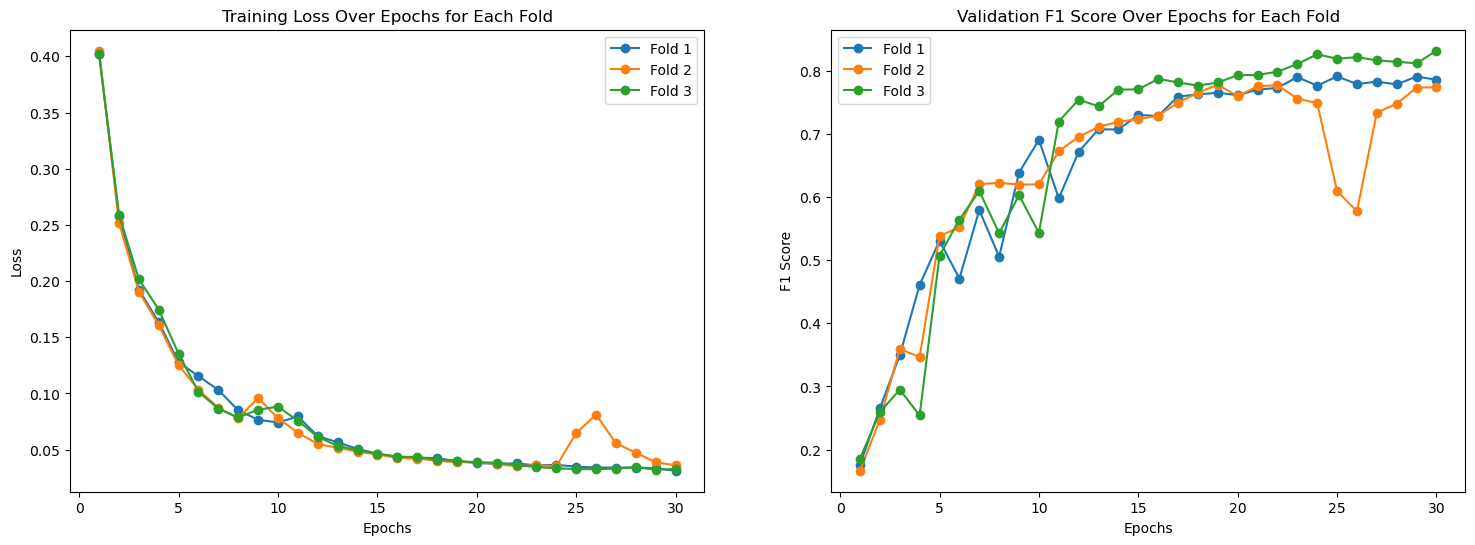

In [ ]:
# Plotting Training Loss and Validation F1 Score for Each Fold
plt.figure(figsize=(18, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
for i, fold_losses in enumerate(all_train_losses, 1):
    plt.plot(range(1, len(fold_losses) + 1), fold_losses, label=f'Fold {i}', marker='o')
plt.title("Training Loss Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Validation F1 Score
plt.subplot(1, 2, 2)
for i, fold_f1 in enumerate(all_val_f1_scores, 1):
    plt.plot(range(1, len(fold_f1) + 1), fold_f1, label=f'Fold {i}', marker='o')
plt.title("Validation F1 Score Over Epochs for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()

plt.show()


**Evaluation on Test Dataset**

In [ ]:
from tqdm import tqdm
from collections import defaultdict
import torch
from torchvision.ops import box_iou, nms
from torchvision.models.detection import retinanet_resnet50_fpn_v2


ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 3  # Number of folds
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = {1: 'depth', 2: 'length', 3: 'width'}

def load_trained_model(weights_path, num_classes, device):
    model = retinanet_resnet50_fpn_v2(pretrained=False)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def collate_fn(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)

def evaluate_custom_with_map_single_fold(faster_model, data_loader, device, iou_thresholds=None, score_threshold=0.5, nms_threshold=0.5):
    if iou_thresholds is None:
        iou_thresholds = [0.5 + 0.05 * i for i in range(10)]  # IoU thresholds from 0.5 to 0.95

    faster_model.eval()

    # Initialize counters for AP per class and IoU threshold
    true_positives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}
    false_positives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}
    false_negatives_per_class = {iou: defaultdict(int) for iou in iou_thresholds}

    # Initialize counters for F1 score
    f1_true_positives = 0
    f1_false_positives = 0
    f1_false_negatives = 0
    f1_iou_threshold = 0.5

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            if not images:
                continue

            images = [img.to(device) for img in images]

            outputs = faster_model(images)

            for output, target in zip(outputs, targets):
                if not isinstance(target, dict):
                    print(f"Unexpected target format: {target}")
                    continue

                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                # Filter by score threshold
                high_conf_idx = pred_scores >= score_threshold
                pred_boxes = pred_boxes[high_conf_idx]
                pred_scores = pred_scores[high_conf_idx]
                pred_labels = pred_labels[high_conf_idx]

                if len(pred_boxes) == 0:
                    # No predictions, all GT boxes are false negatives
                    for gt_label in gt_labels:
                        class_name = class_names.get(gt_label.item(), 'unknown')
                        for iou in iou_thresholds:
                            false_negatives_per_class[iou][class_name] += 1
                    # Update F1 false negatives
                    f1_false_negatives += len(gt_labels)
                    continue

                # Apply Non-Maximum Suppression (NMS)
                keep_indices = nms(pred_boxes, pred_scores, nms_threshold)
                pred_boxes = pred_boxes[keep_indices]
                pred_scores = pred_scores[keep_indices]
                pred_labels = pred_labels[keep_indices]

                if len(pred_boxes) == 0:
                    # No predictions after NMS, all GT boxes are false negatives
                    for gt_label in gt_labels:
                        class_name = class_names.get(gt_label.item(), 'unknown')
                        for iou in iou_thresholds:
                            false_negatives_per_class[iou][class_name] += 1
                    # Update F1 false negatives
                    f1_false_negatives += len(gt_labels)
                    continue

                # Compute IoU between predicted and ground truth boxes
                ious = box_iou(pred_boxes, gt_boxes)

                # --- mAP Calculation ---
                for iou_threshold in iou_thresholds:
                    matched_pred = torch.zeros(len(pred_boxes), dtype=torch.bool).to(device)
                    matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool).to(device)

                    for pred_idx in range(len(pred_boxes)):
                        iou_vals = ious[pred_idx]
                        max_iou, gt_idx = torch.max(iou_vals, dim=0)

                        if max_iou >= iou_threshold and not matched_gt[gt_idx]:
                            matched_pred[pred_idx] = True
                            matched_gt[gt_idx] = True
                            class_name = class_names.get(gt_labels[gt_idx].item(), 'unknown')
                            true_positives_per_class[iou_threshold][class_name] += 1
                        else:
                            class_name = class_names.get(pred_labels[pred_idx].item(), 'unknown')
                            false_positives_per_class[iou_threshold][class_name] += 1

                    for gt_idx in range(len(gt_boxes)):
                        if not matched_gt[gt_idx]:
                            class_name = class_names.get(gt_labels[gt_idx].item(), 'unknown')
                            false_negatives_per_class[iou_threshold][class_name] += 1

                # --- F1 Score Calculation ---
                # For F1, use fixed IoU threshold of 0.5
                if f1_iou_threshold in iou_thresholds:
                    # Find matches with IoU >= 0.5
                    matched_pred_f1 = torch.zeros(len(pred_boxes), dtype=torch.bool).to(device)
                    matched_gt_f1 = torch.zeros(len(gt_boxes), dtype=torch.bool).to(device)

                    for pred_idx in range(len(pred_boxes)):
                        iou_val = ious[pred_idx]
                        max_iou, gt_idx = torch.max(iou_val, dim=0)
                        if max_iou >= f1_iou_threshold and not matched_gt_f1[gt_idx]:
                            matched_pred_f1[pred_idx] = True
                            matched_gt_f1[gt_idx] = True
                            f1_true_positives += 1
                        else:
                            f1_false_positives += 1

                    # Count unmatched ground truths as false negatives
                    f1_false_negatives += (~matched_gt_f1).sum().item()

        # --- Calculate mAP ---
        mean_ap = 0
        per_class_map = defaultdict(list)  # To store per-class AP
        for iou_threshold in iou_thresholds:
            ap_per_class = []

            for class_name in class_names.values():
                tp = true_positives_per_class[iou_threshold][class_name]
                fp = false_positives_per_class[iou_threshold][class_name]
                fn = false_negatives_per_class[iou_threshold][class_name]

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                ap = precision  # AP is precision at the fixed IoU threshold
                ap_per_class.append(ap)
                per_class_map[class_name].append(ap)

            mean_ap += sum(ap_per_class) / len(ap_per_class) if ap_per_class else 0

        mean_ap /= len(iou_thresholds)

        # --- Calculate F1 Score ---
        precision_f1 = f1_true_positives / (f1_true_positives + f1_false_positives) if (f1_true_positives + f1_false_positives) > 0 else 0
        recall_f1 = f1_true_positives / (f1_true_positives + f1_false_negatives) if (f1_true_positives + f1_false_negatives) > 0 else 0
        f1_score = 2 * (precision_f1 * recall_f1) / (precision_f1 + recall_f1) if (precision_f1 + recall_f1) > 0 else 0

        return {
            'mean_ap': mean_ap,
            'class_map': per_class_map,
            'f1_score': f1_score
        }

fold_metrics = []

for fold in range(1, K+1):
    print(f"\n--- Evaluating Fold {fold} ---")

    fold_dir = os.path.join(FOLDS_DIR, f'fold_{fold}')
    model_weights_path = os.path.join(fold_dir, 'RetinaNet_best.pt')

    # Check if the model weights exist
    if not os.path.exists(model_weights_path):
        print(f"Model weights not found for Fold {fold} at {model_weights_path}. Skipping this fold.")
        continue

    # Load the trained model
    model = load_trained_model(model_weights_path, NUM_CLASSES, DEVICE)
    print(f"Loaded model for Fold {fold} from {model_weights_path}")

    # Load the validation dataset and DataLoader for this fold
    val_annotations_file = os.path.join(fold_dir, 'val', 'annotations', '_annotations.coco.json')
    val_images_dir = os.path.join(fold_dir, 'val', 'images')

    # Initialize the validation dataset
    val_dataset = CustomDataset(val_annotations_file, val_images_dir, transform=transform)

    # Initialize the DataLoader
    val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

    # Evaluate the model on the validation set
    metrics = evaluate_custom_with_map_single_fold(
        faster_model=model,
        data_loader=val_data_loader,
        device=DEVICE,
        iou_thresholds=[0.5 + 0.05 * i for i in range(10)],  # IoU thresholds from 0.5 to 0.95
        score_threshold=0.5,  # Ensure consistency with training
        nms_threshold=0.5
    )

    # Store the metrics along with the fold number
    fold_metrics.append({
        'fold': fold,
        'mean_ap': metrics['mean_ap'],
        'f1_score': metrics['f1_score'],
        'class_map': metrics['class_map']
    })


--- Evaluating Fold 1 ---


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3475939/2026366589.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only

Loaded model for Fold 1 from Methodology.2.v5i.coco/folds/fold_1/RetinaNet_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 276/276 [00:12<00:00, 21.42it/s]



--- Evaluating Fold 2 ---
Loaded model for Fold 2 from Methodology.2.v5i.coco/folds/fold_2/RetinaNet_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.91it/s]



--- Evaluating Fold 3 ---
Loaded model for Fold 3 from Methodology.2.v5i.coco/folds/fold_3/RetinaNet_best.pt


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 275/275 [00:12<00:00, 21.83it/s]


In [ ]:
total_map = sum([m['mean_ap'] for m in fold_metrics])

average_map = total_map / len(fold_metrics)
average_f1 = sum(best_f1_scores) / len(fold_metrics)

# Print detailed metrics for each fold
print("\n=== Cross-Validation Results ===")
print(f"Average F1 Score across all folds: {average_f1:.4f}")
print(f"Average mAP@0.5:0.95 across all folds: {average_map:.4f}")


=== Cross-Validation Results ===
Average F1 Score across all folds: 0.8001
Average mAP@0.5:0.95 across all folds: 0.7475


**Prediction Sample Image**

/tmp/ipykernel_2109244/3369208187.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Loaded Faster R-CNN model from fold_1
Loaded Faster R-CNN model from fold_2
Loaded Faster R-CNN model from fold_3
Model Fold 1 - Detections: 3
Model Fold 2 - Detections: 3
Model Fold 3 - Detections: 3
Final Detections after Ensembling 5 folds: 3


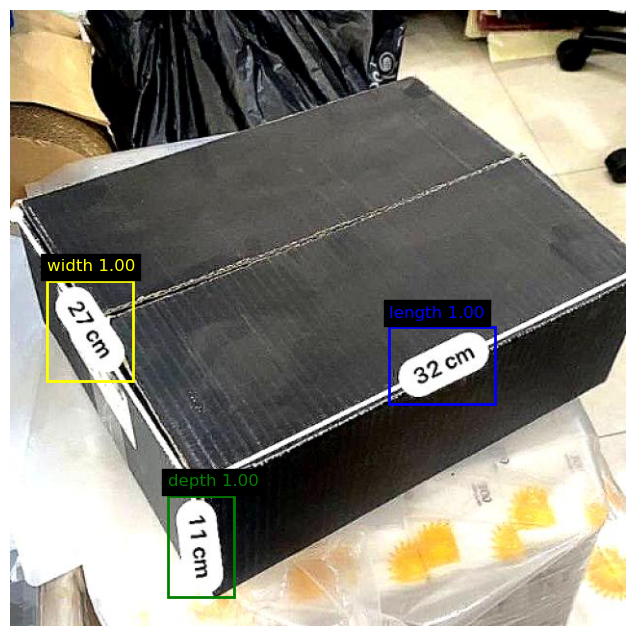

In [ ]:
import os
import torch
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.ops import nms, box_iou
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm


ROOT_DIR = 'Methodology.2.v5i.coco'
FOLDS_DIR = os.path.join(ROOT_DIR, 'folds')
K = 3  # Number of folds
NUM_CLASSES = 3  # 3 classes + background
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = {1: 'depth', 2: 'length', 3: 'width'}


transform = transforms.Compose([transforms.ToTensor()])


def load_trained_model(weights_path, num_classes, device):
    """
    Load a trained RetinaNet model.
    """
    model = retinanet_resnet50_fpn_v2(pretrained=False)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model


models = []
for fold in range(1, K+1):
    weights_path = os.path.join(FOLDS_DIR, f'fold_{fold}', 'RetinaNet_best.pt')
    if os.path.exists(weights_path):
        model = load_trained_model(weights_path, NUM_CLASSES, DEVICE)
        models.append(model)
        print(f"Loaded Faster R-CNN model from fold_{fold}")
    else:
        print(f"Model weights not found for fold_{fold} at {weights_path}")


test_image_path = "Methodology.2.v5i.coco/train/GG_methodology2_-101-_jpg.rf.2e49ac1d30e88a1f960a2ef177433a1b.jpg"  # Update this path as needed


image = Image.open(test_image_path).convert("RGB")
image_tensor = transform(image).to(DEVICE)

all_boxes = []
all_scores = []
all_labels = []

for idx, model in enumerate(models):
    with torch.no_grad():
        predictions = model([image_tensor])[0]

    boxes = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']

    # Filter out low-confidence predictions
    high_conf_idx = scores >= 0.5
    boxes = boxes[high_conf_idx]
    scores = scores[high_conf_idx]
    labels = labels[high_conf_idx]

    all_boxes.append(boxes)
    all_scores.append(scores)
    all_labels.append(labels)

    print(f"Model Fold {idx+1} - Detections: {len(boxes)}")


if all_boxes:
    all_boxes = torch.cat(all_boxes)
    all_scores = torch.cat(all_scores)
    all_labels = torch.cat(all_labels)
else:
    all_boxes = torch.empty((0, 4)).to(DEVICE)
    all_scores = torch.empty((0,)).to(DEVICE)
    all_labels = torch.empty((0,), dtype=torch.int64).to(DEVICE)


iou_threshold = 0.5

final_boxes = []
final_scores = []
final_labels = []

unique_labels = all_labels.unique()

for label in unique_labels:
    label_mask = all_labels == label
    boxes = all_boxes[label_mask]
    scores = all_scores[label_mask]

    if boxes.numel() == 0:
        continue

    if len(boxes) > 3:
        # Take only the most confident box
        top_score_idx = torch.argmax(scores)
        final_boxes.append(boxes[top_score_idx].unsqueeze(0))
        final_scores.append(scores[top_score_idx].unsqueeze(0))
        final_labels.append(all_labels[label_mask][top_score_idx].unsqueeze(0))
    else:
        # Apply NMS and keep all boxes
        keep = nms(boxes, scores, iou_threshold)
        final_boxes.append(boxes[keep])
        final_scores.append(scores[keep])
        final_labels.append(all_labels[label_mask][keep])

if final_boxes:
    final_boxes = torch.cat(final_boxes).cpu()
    final_scores = torch.cat(final_scores).cpu()
    final_labels = torch.cat(final_labels).cpu()
else:
    final_boxes = torch.empty((0, 4))
    final_scores = torch.empty((0,))
    final_labels = torch.empty((0,), dtype=torch.int64)

print(f"Final Detections after Ensembling 5 folds: {len(final_boxes)}")

def draw_boxes(image_path, boxes, scores, labels, class_names):
    """
    Draw bounding boxes on the image.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan']

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        width, height = x2 - x1, y2 - y1
        color = colors[label % len(colors)]
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        class_name = class_names.get(label.item(), 'Unknown')
        plt.text(x1, y1 - 10, f"{class_name} {score:.2f}", fontsize=12, color=color, backgroundcolor="black")

    plt.axis('off')
    plt.show()


class_names_list = ['depth', 'length', 'width']
draw_boxes(test_image_path, final_boxes, final_scores, final_labels, class_names)

# Ensemble Learning

In [ ]:
# Import necessary libraries
import torch
from torchvision.ops import nms
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure image is RGB
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    image_size = image.size  # (width, height)
    return image_tensor, image_size

# Define function to get predictions from Faster R-CNN
def get_faster_rcnn_predictions(faster_model, image_tensor):
    faster_model.eval()
    with torch.no_grad():
        outputs = faster_model(image_tensor)[0]
    boxes = outputs['boxes']
    scores = outputs['scores']
    labels = outputs['labels']
    return boxes, scores, labels

# Define function to get predictions from RetinaNet
def get_retina_net_predictions(retina_model, image_tensor):
    retina_model.eval()
    with torch.no_grad():
        outputs = retina_model(image_tensor)[0]
    boxes = outputs['boxes']
    scores = outputs['scores']
    labels = outputs['labels']
    return boxes, scores, labels

# Define function to get predictions from YOLO
def get_yolo_predictions(yolo_model, image_path, image_size):
    yolo_results = yolo_model.predict(image_path)

    yolo_boxes = []
    yolo_scores = []
    yolo_labels = []

    for result in yolo_results:
        boxes = result.boxes.xyxy  # [x1, y1, x2, y2]
        scores = result.boxes.conf
        labels = result.boxes.cls

        # Convert labels to integers
        labels = labels.long()

        # Check if boxes are normalized (values between 0 and 1)
        if torch.max(boxes) <= 1.0:
            width, height = image_size
            scale = torch.tensor([width, height, width, height]).to(device)
            boxes = boxes * scale

        yolo_boxes.append(boxes)
        yolo_scores.append(scores)
        yolo_labels.append(labels)

    # Flatten YOLO predictions
    if yolo_boxes:
        yolo_boxes = torch.cat(yolo_boxes, dim=0)
        yolo_scores = torch.cat(yolo_scores, dim=0)
        yolo_labels = torch.cat(yolo_labels, dim=0)
    else:
        yolo_boxes = torch.empty((0, 4)).to(device)
        yolo_scores = torch.empty((0,)).to(device)
        yolo_labels = torch.empty((0,), dtype=torch.int64).to(device)

    return yolo_boxes, yolo_scores, yolo_labels

# Define function to perform ensemble Non-Maximum Suppression (NMS)
def ensemble_nms(all_boxes, all_scores, all_labels, iou_threshold=0.5):
    keep = nms(all_boxes, all_scores, iou_threshold)
    final_boxes = all_boxes[keep]
    final_scores = all_scores[keep]
    final_labels = all_labels[keep]
    return final_boxes, final_scores, final_labels


In [ ]:
# Import model architectures from torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, retinanet_resnet50_fpn_v2

# Define K-Fold
K = 3  # Number of folds

# Define paths to the saved model weights for each fold
# Assuming models are saved in 'fold_{fold}/fasterrcnn_best.pt', etc.
fasterrcnn_weights_paths = [os.path.join("Methodology.2.v5i.coco","folds", f'fold_{fold}', 'fasterrcnn_best.pt') for fold in range(1, K+1)]
retinanet_weights_paths = [os.path.join("Methodology.2.v5i.coco","folds", f'fold_{fold}', 'RetinaNet_best.pt') for fold in range(1, K+1)]
yolo_weights_paths = [os.path.join("folds2", f'fold_{fold}', 'runs', 'train', 'weights', 'best.pt') for fold in range(1, K+1)]

# Load all Faster R-CNN models
faster_models = []
for fold, path in enumerate(fasterrcnn_weights_paths, 1):
    if os.path.exists(path):
        model = fasterrcnn_resnet50_fpn_v2(pretrained=False).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        faster_models.append(model)
        print(f"Loaded Faster R-CNN model for Fold {fold} from {path}")
    else:
        print(f"Faster R-CNN weights not found for Fold {fold} at {path}")

# Load all RetinaNet models
retina_models = []
for fold, path in enumerate(retinanet_weights_paths, 1):
    if os.path.exists(path):
        model = retinanet_resnet50_fpn_v2(pretrained=False).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        retina_models.append(model)
        print(f"Loaded RetinaNet model for Fold {fold} from {path}")
    else:
        print(f"RetinaNet weights not found for Fold {fold} at {path}")

# Load all YOLO models using Ultralytics
yolo_models = []
for fold, path in enumerate(yolo_weights_paths, 1):
    if os.path.exists(path):
        model = YOLO(path)
        yolo_models.append(model)
        print(f"Loaded YOLO model for Fold {fold} from {path}")
    else:
        print(f"YOLO weights not found for Fold {fold} at {path}")


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded Faster R-CNN model for Fold 1 from Methodology.2.v5i.coco/folds/fold_1/fasterrcnn_best.pt
Loaded Faster R-CNN model for Fold 2 from Methodology.2.v5i.coco/folds/fold_2/fasterrcnn_best.pt
Loaded Faster R-CNN model for Fold 3 from Methodology.2.v5i.coco/folds/fold_3/fasterrcnn_best.pt
Loaded RetinaNet model for Fold 1 from Methodology.2.v5i.coco/folds/fold_1/RetinaNet_best.pt
Loaded RetinaNet model for Fold 2 from Methodology.2.v5i.coco/folds/fold_2/RetinaNet_best.pt
Loaded RetinaNet model for Fold 3 from Methodology.2.v5i.coco/folds/fold_3/RetinaNet_best.pt
Loaded YOLO model for Fold 1 from folds2/fold_1/runs/train/weights/best.pt
Loaded YOLO model for Fold 2 from folds2/fold_2/runs/train/weights/best.pt
Loaded YOLO model for Fold 3 from folds2/fold_3/runs/train/weights/best.pt


In [ ]:
# Path to the image
image_path = r"Methodology.2.v5i.coco/train/GG_methodology2_-108-_jpg.rf.43611b3467ded97a80ca66e0cde245d4.jpg"

# Load and preprocess the image
image_tensor, image_size = load_image(image_path)

# Initialize lists to store predictions from all models across all folds
all_faster_boxes = []
all_faster_scores = []
all_faster_labels = []

all_retina_boxes = []
all_retina_scores = []
all_retina_labels = []

all_yolo_boxes = []
all_yolo_scores = []
all_yolo_labels = []

# Get predictions from all Faster R-CNN models
for idx, model in enumerate(faster_models, 1):
    boxes, scores, labels = get_faster_rcnn_predictions(model, image_tensor)
    all_faster_boxes.append(boxes)
    all_faster_scores.append(scores)
    all_faster_labels.append(labels)
    print(f"Faster R-CNN Fold {idx} - Detections: {len(boxes)}")

# Get predictions from all RetinaNet models
for idx, model in enumerate(retina_models, 1):
    boxes, scores, labels = get_retina_net_predictions(model, image_tensor)
    all_retina_boxes.append(boxes)
    all_retina_scores.append(scores)
    all_retina_labels.append(labels)
    print(f"RetinaNet Fold {idx} - Detections: {len(boxes)}")

# Get predictions from all YOLO models
for idx, model in enumerate(yolo_models, 1):
    boxes, scores, labels = get_yolo_predictions(model, image_path, image_size)
    all_yolo_boxes.append(boxes)
    all_yolo_scores.append(scores)
    all_yolo_labels.append(labels)
    print(f"YOLO Fold {idx} - Detections: {len(boxes)}")


Faster R-CNN Fold 1 - Detections: 4
Faster R-CNN Fold 2 - Detections: 3
Faster R-CNN Fold 3 - Detections: 3
RetinaNet Fold 1 - Detections: 4
RetinaNet Fold 2 - Detections: 4
RetinaNet Fold 3 - Detections: 3

image 1/1 /home/hamidme/Methodology.2.v5i.coco/train/GG_methodology2_-108-_jpg.rf.43611b3467ded97a80ca66e0cde245d4.jpg: 640x640 2 depths, 1 length, 2 widths, 19.6ms
Speed: 1.1ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
YOLO Fold 1 - Detections: 5

image 1/1 /home/hamidme/Methodology.2.v5i.coco/train/GG_methodology2_-108-_jpg.rf.43611b3467ded97a80ca66e0cde245d4.jpg: 640x640 2 depths, 1 length, 1 width, 14.2ms
Speed: 1.3ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
YOLO Fold 2 - Detections: 4

image 1/1 /home/hamidme/Methodology.2.v5i.coco/train/GG_methodology2_-108-_jpg.rf.43611b3467ded97a80ca66e0cde245d4.jpg: 640x640 2 depths, 1 length, 1 width, 6.2ms
Speed: 11.3ms preprocess, 6.2ms inference, 13.0m

In [ ]:
# Combine all Faster R-CNN predictions
if all_faster_boxes:
    faster_boxes_combined = torch.cat(all_faster_boxes, dim=0)
    faster_scores_combined = torch.cat(all_faster_scores, dim=0)
    faster_labels_combined = torch.cat(all_faster_labels, dim=0)
else:
    faster_boxes_combined = torch.empty((0, 4)).to(device)
    faster_scores_combined = torch.empty((0,)).to(device)
    faster_labels_combined = torch.empty((0,), dtype=torch.int64).to(device)

# Combine all RetinaNet predictions
if all_retina_boxes:
    retina_boxes_combined = torch.cat(all_retina_boxes, dim=0)
    retina_scores_combined = torch.cat(all_retina_scores, dim=0)
    retina_labels_combined = torch.cat(all_retina_labels, dim=0)
else:
    retina_boxes_combined = torch.empty((0, 4)).to(device)
    retina_scores_combined = torch.empty((0,)).to(device)
    retina_labels_combined = torch.empty((0,), dtype=torch.int64).to(device)

# Combine all YOLO predictions
if all_yolo_boxes:
    yolo_boxes_combined = torch.cat(all_yolo_boxes, dim=0)
    yolo_scores_combined = torch.cat(all_yolo_scores, dim=0)
    yolo_labels_combined = torch.cat(all_yolo_labels, dim=0)
else:
    yolo_boxes_combined = torch.empty((0, 4)).to(device)
    yolo_scores_combined = torch.empty((0,)).to(device)
    yolo_labels_combined = torch.empty((0,), dtype=torch.int64).to(device)

# Combine all boxes, scores, and labels from all architectures
all_boxes = torch.cat([faster_boxes_combined, retina_boxes_combined, yolo_boxes_combined], dim=0)
all_scores = torch.cat([faster_scores_combined, retina_scores_combined, yolo_scores_combined], dim=0)
all_labels = torch.cat([faster_labels_combined, retina_labels_combined, yolo_labels_combined], dim=0)

print(f"Total Detections Before NMS: {len(all_boxes)}")


Total Detections Before NMS: 34


In [ ]:
# Define IoU threshold for NMS
iou_threshold = 0.5

# Initialize lists to store final detections
final_boxes = []
final_scores = []
final_labels = []

# Get unique class labels, excluding the background class (assumed to be 0)
unique_labels = all_labels.unique()
unique_labels = unique_labels[unique_labels != 0]  # Exclude background

for label in unique_labels:
    label_mask = all_labels == label
    boxes = all_boxes[label_mask]
    scores = all_scores[label_mask]
    labels_subset = all_labels[label_mask]  # Define labels_subset for correct indexing

    if boxes.numel() == 0:
        continue

    if len(boxes) > 3:
        # Take only the most confident box
        top_score, top_idx = torch.max(scores, dim=0)
        final_boxes.append(boxes[top_idx].unsqueeze(0))
        final_scores.append(scores[top_idx].unsqueeze(0))
        final_labels.append(labels_subset[top_idx].unsqueeze(0))
    else:
        # Apply standard NMS and keep all boxes
        keep = nms(boxes, scores, iou_threshold)
        final_boxes.append(boxes[keep])
        final_scores.append(scores[keep])
        final_labels.append(labels_subset[keep])

# Concatenate all final detections
if final_boxes:
    final_boxes = torch.cat(final_boxes).cpu()
    final_scores = torch.cat(final_scores).cpu()
    final_labels = torch.cat(final_labels).cpu()
else:
    final_boxes = torch.empty((0, 4))
    final_scores = torch.empty((0,))
    final_labels = torch.empty((0,), dtype=torch.int64)

print(f"Final Detections after Modified NMS: {len(final_boxes)}")


Final Detections after Modified NMS: 3


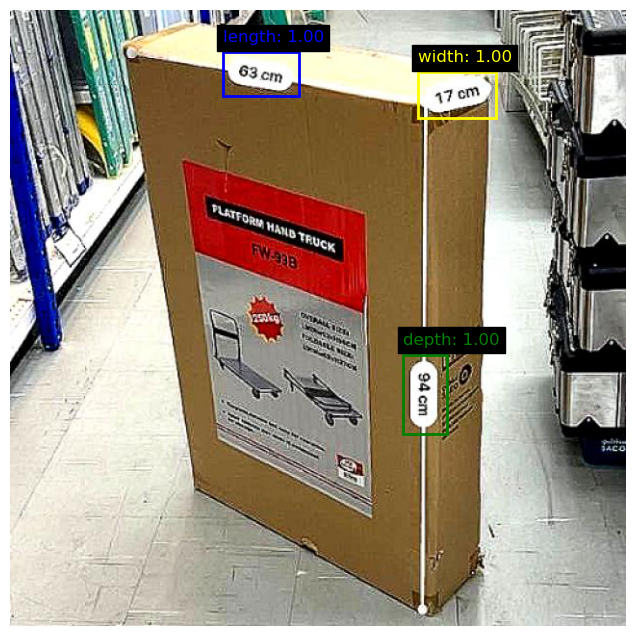

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Visualization helper function
def visualize_predictions(image_path, boxes, labels, scores, class_names, threshold=0.5, figure_size=(12, 8)):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    plt.figure(figsize=figure_size)
    plt.imshow(image)
    ax = plt.gca()

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan']

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue
        x_min, y_min, x_max, y_max = box.tolist()
        width, height = x_max - x_min, y_max - y_min
        color = colors[label.numpy().astype(int) % len(colors)]
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        class_name = class_names.get(int(label.item()), 'Unknown')  # Ensure label is an integer
        plt.text(x_min, y_min - 10, f"{class_name}: {score:.2f}", fontsize=12, color=color, backgroundcolor="black")

    plt.axis('off')
    plt.show()

# Define class names (ensure they match your training)
class_names = {1: 'depth', 2: 'length', 3: 'width'}  # Adjust as per your dataset

# Draw the final boxes on the image
if len(final_boxes) > 0:
    visualize_predictions(image_path, final_boxes, final_labels, final_scores, class_names, threshold=0.5)
else:
    print("No boxes to display.")
